# Perfil comercial de um país

Perfil comercial de um país. O objetivo é analisar as trocas comerciais de um país com o resto do mundo.

Mais informação em [country_trade_profile_README.md](country_trade_profile_README.md)

## Setup

For instructions and how to obtain an API key, see [here](0-comtrade-setup-first.ipynb).

In [2]:
import logging
import sys

# Configure logging to output to stdout and set level to DEBUG
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)

# Example debug message
logging.debug("This is a debug message")

DEBUG:root:This is a debug message


In [3]:
import comtradetools as comtradetools

comtradetools.setup()
APIKEY = comtradetools.get_api_key()
comtradetools.init(APIKEY, force_init=False)

INFO:root:Loading HS codes from support/harmonized-system.csv


## Country and period of interest

Choose country and years of interest

In [4]:
import comtradetools


country_of_interest_name = 'Brazil'
country_of_interest = comtradetools.encode_country(country_of_interest_name)

years_of_interest=comtradetools.year_range(2003,2023)
print(country_of_interest_name, years_of_interest)

Brazil 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023


## 1.Trade balance

### 1a Trade balance symmetric values

In [5]:
import comtradetools
import pandas as pd
import numpy as np

pd.options.display.float_format = '{:,.2f}'.format

periods = comtradetools.split_period(years_of_interest,6)
global_trade = pd.DataFrame()
for period in periods:
    print(f"Fetching data for period {period}")

    temp = comtradetools.get_trade_flows(country_of_interest,
                                            period=period,
                                            symmetric_values=True)

    global_trade = pd.concat([global_trade,temp])


global_trade = global_trade.replace(0, np.nan)
cols_of_interest = global_trade.columns



Fetching data for period 2003,2004,2005,2006,2007,2008
INFO:root:Calling getFinalData for period 2003,2004,2005,2006,2007,2008
DEBUG:root:Call ('b5cdc1c0678544b0ab5085f7292e6643',){'typeCode': 'C', 'freqCode': 'A', 'reporterCode': 76, 'partnerCode': 0, 'partner2Code': 0, 'flowCode': 'M', 'period': '2003,2004,2005,2006,2007,2008', 'motCode': 0, 'customsCode': 'C00', 'cmdCode': 'TOTAL', 'clCode': 'HS', 'includeDesc': True}False
INFO:root:Using cached results for period 2003,2004,2005,2006,2007,2008
INFO:root:Calling getFinalData for period 2003,2004,2005,2006,2007,2008
DEBUG:root:Call ('b5cdc1c0678544b0ab5085f7292e6643',){'typeCode': 'C', 'freqCode': 'A', 'reporterCode': 76, 'partnerCode': 0, 'partner2Code': 0, 'flowCode': 'X', 'period': '2003,2004,2005,2006,2007,2008', 'clCode': 'HS', 'cmdCode': 'TOTAL', 'customsCode': 'C00', 'motCode': 0, 'includeDesc': True}False
INFO:root:Using cached results for period 2003,2004,2005,2006,2007,2008
INFO:root:Calling getFinalData for period 2003,2004

In [6]:
global_trade['varM_perc']=global_trade['M']/global_trade['M<X']
global_trade['varX_perc']=global_trade['X']/global_trade['X<M']
print(f"M = Imports as reported by {country_of_interest_name}")
print(f"X = Exports as reported by {country_of_interest_name}")
print(f"X<M = Exports as reported by rest of the world imports from {country_of_interest_name}")
print(f"M<X = Imports as reported by rest of the world exports to {country_of_interest_name}")
global_trade


M = Imports as reported by Brazil
X = Exports as reported by Brazil
X<M = Exports as reported by rest of the world imports from Brazil
M<X = Imports as reported by rest of the world exports to Brazil


flowCode,M,M<X,X,X<M,trade_balance (X-M),trade_balance (X<M-M),trade_volume (X+M),trade_volume (X<M+M),varM_perc,varX_perc
period,,,,,,,,,,
2003,"51,866,683,099.00","48,163,351,649.58","72,772,250,490.00","80,938,016,740.10","20,905,567,391.00","29,071,333,641.10","124,638,933,589.00","132,804,699,839.10",1.08,0.90
2004,"67,459,080,324.00","60,210,514,963.47","95,115,400,894.00","106,772,382,904.26","27,656,320,570.00","39,313,302,580.26","162,574,481,218.00","174,231,463,228.26",1.12,0.89
2005,"78,702,313,940.00","72,404,776,113.52","118,592,084,489.00","128,267,531,762.49","39,889,770,549.00","49,565,217,822.49","197,294,398,429.00","206,969,845,702.49",1.09,0.92
2006,"97,033,998,543.00","91,526,548,685.39","137,574,211,351.00","146,309,567,617.55","40,540,212,808.00","49,275,569,074.55","234,608,209,894.00","243,343,566,160.55",1.06,0.94
2007,"128,110,615,840.00","119,723,310,111.21","159,816,180,731.00","175,460,738,687.32","31,705,564,891.00","47,350,122,847.32","287,926,796,571.00","303,571,354,527.32",1.07,0.91
2008,"183,920,682,149.00","169,297,398,392.29","195,764,624,177.00","219,226,645,342.07","11,843,942,028.00","35,305,963,193.07","379,685,306,326.00","403,147,327,491.07",1.09,0.89
2009,"135,377,600,478.00","126,801,533,617.09","151,791,674,186.00","168,311,713,288.99","16,414,073,708.00","32,934,112,810.99","287,169,274,664.00","303,689,313,766.99",1.07,0.90
2010,"193,184,261,936.00","183,007,964,920.99","200,433,952,776.00","215,585,883,306.29","7,249,690,840.00","22,401,621,370.29","393,618,214,712.00","408,770,145,242.29",1.06,0.93
2011,"238,706,132,375.00","227,782,224,414.95","253,665,436,795.00","274,344,008,669.15","14,959,304,420.00","35,637,876,294.15","492,371,569,170.00","513,050,141,044.15",1.05,0.92


Save to Excel file

In [7]:
start_year=global_trade.index.min()
end_year=global_trade.index.max()
excel_file = f"reports/{country_of_interest_name}_1.1_trade_balance_{start_year}-{end_year}.xlsx"
global_trade.to_excel(excel_file)
print("Trade ballance report saved to ", excel_file)

Trade ballance report saved to  reports/Brazil_1.1_trade_balance_2003-2023.xlsx


### Trade balance graph

DEBUG:matplotlib:matplotlib data path: /Users/jrc/develop/cipf-comtrade/venv/lib/python3.10/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:CONFIGDIR=/Users/jrc/.matplotlib
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is darwin
DEBUG:matplotlib:CACHEDIR=/Users/jrc/.matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /Users/jrc/.matplotlib/fontlist-v390.json
Plot saved to  reports/Brazil_1.2_trade_balance_2003-2023.png
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/jrc/develop/cipf-comtrade/venv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansDisplay.ttf', name='DejaVu Sans Display'

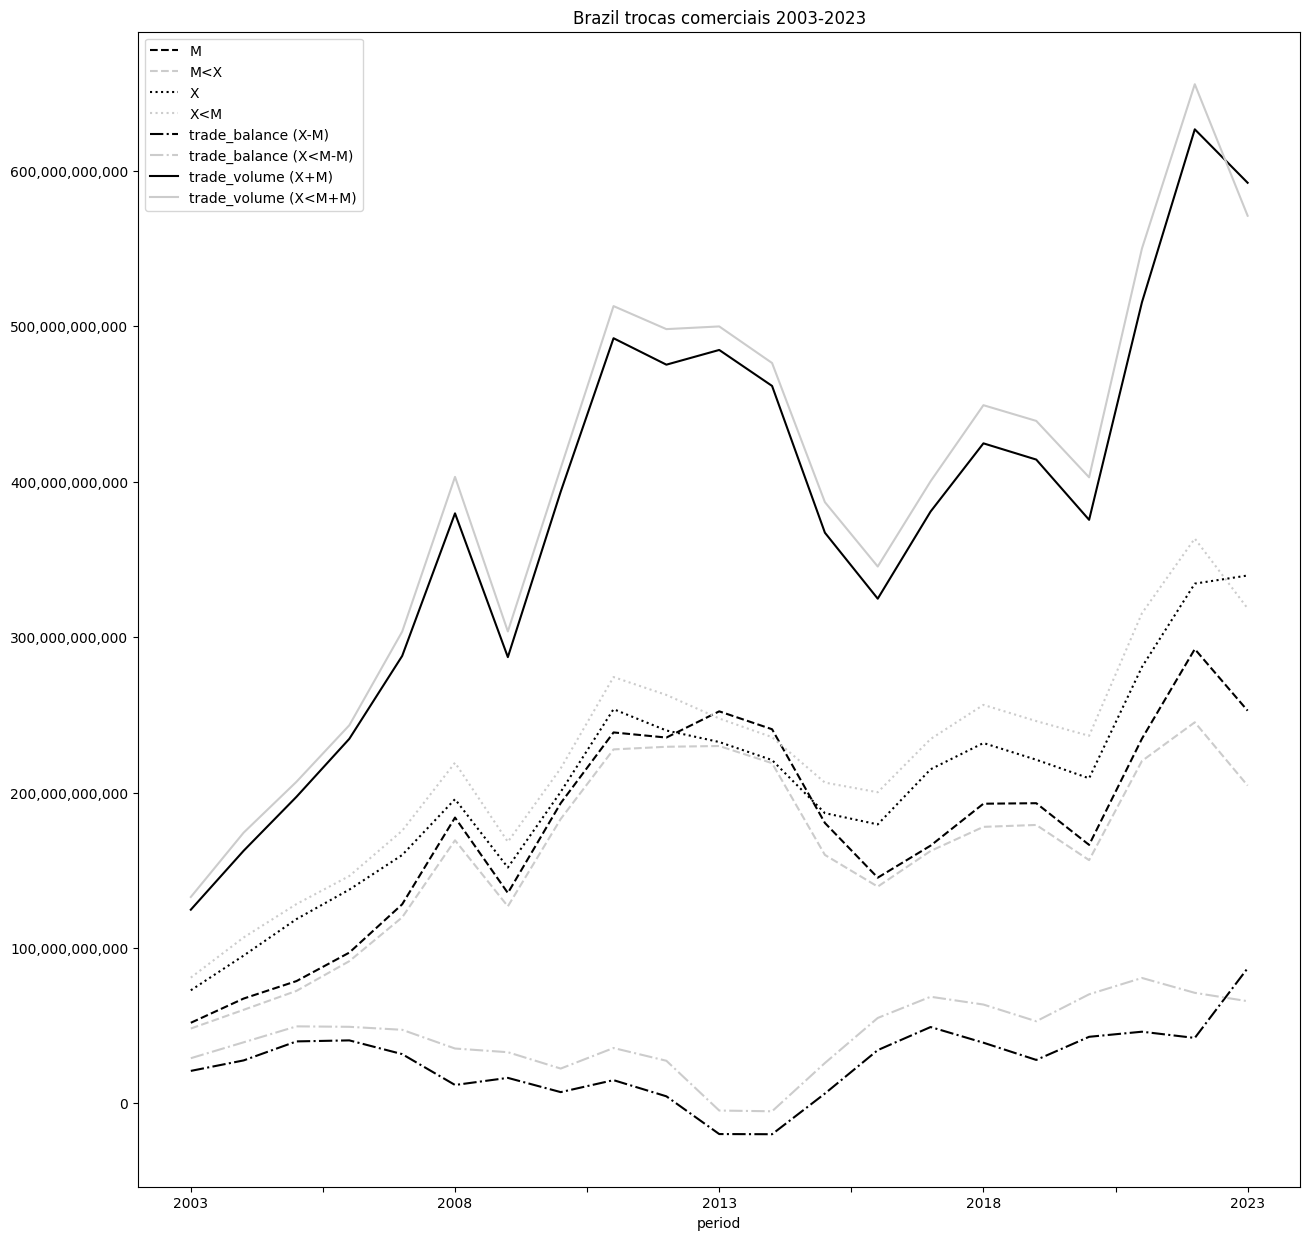

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plotfile = f"reports/{country_of_interest_name}_1.2_trade_balance_{start_year}-{end_year}.png"

start_year=global_trade.index.min()
end_year=global_trade.index.max()
title=f"{country_of_interest_name} trocas comerciais {start_year}-{end_year}"
print("Plot saved to ", plotfile)
fig = global_trade[cols_of_interest].plot.line(figsize=(15,15),title=title)

# use a grayscale palette of colors
colors = ['0.0','0.8','0.0','0.8','0.0','0.8','0.0','0.8']

# use different line styles and black lines
linestyles = ['dashed', 'dashed', 'dotted', 'dotted', 'dashdot', 'dashdot', 'solid', 'solid']
for i, line in enumerate(fig.get_lines()):
    print(i, line, colors[i])
    line.set_color(colors[i])
    line.set_linestyle(linestyles[i % len(linestyles)])

formatter = ticker.StrMethodFormatter('{x:,.0f}')
fig.yaxis.set_major_formatter(formatter)
fig.legend(list(global_trade.columns.astype(str)))

plt.savefig(plotfile)
plt.show()

## 2. Exports


### 2.1 Main export partners/clients

Colect destinations of exports of the country. 

Use either reported exports
of country of interest, or reported imports from country of interest by
all other countries (symmetric reporting). 

Set variable `symmetric_reporting` to choose.

In [111]:
# If symmetric_reporting is "True" we get the exports from
#    the reported imports of all the countries
# i.e. instead of asking Country of Interest for export data we ask the world
#    for import data from Country of Interest

symmetric_reporting = True  # set to false to use reported exports by Country of Interest

if symmetric_reporting:
    reporterCode = None
    partnerCode = country_of_interest
    flowCode = 'M'
    reporter_column = 'partner'
    partner_column = 'reporter'
else:
    reporterCode = country_of_interest
    partnerCode = None
    flowCode = 'X'
    reporter_column = 'reporter'
    partner_column = 'partner'


In [112]:

# years_of_interest = comtrade.year_range(2020, 2021)
df = comtradetools.getFinalData(APIKEY,
                                reporterCode=reporterCode,
                                typeCode='C',  # commodities
                                freqCode='A',  # annual
                                flowCode=flowCode,
                                period=years_of_interest,
                                partnerCode=partnerCode,
                                remove_world=True,
                                partner2Code=0,  # world
                                clCode="HS",
                                cmdCode="TOTAL",
                                motCode=0,  # all means of transport
                                customsCode='C00', # all customs
                                includeDesc=True,
                                cache=True
                                )

INFO:root:Calling getFinalData for period 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
DEBUG:root:Call ('b5cdc1c0678544b0ab5085f7292e6643',){'reporterCode': None, 'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'M', 'period': '2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014', 'partnerCode': 76, 'partner2Code': 0, 'clCode': 'HS', 'cmdCode': 'TOTAL', 'motCode': 0, 'customsCode': 'C00', 'includeDesc': True}False
INFO:root:Using cached results for period 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
INFO:root:Calling getFinalData for period 2015,2016,2017,2018,2019,2020,2021,2022,2023
DEBUG:root:Call ('b5cdc1c0678544b0ab5085f7292e6643',){'reporterCode': None, 'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'M', 'period': '2015,2016,2017,2018,2019,2020,2021,2022,2023', 'partnerCode': 76, 'partner2Code': 0, 'clCode': 'HS', 'cmdCode': 'TOTAL', 'motCode': 0, 'customsCode': 'C00', 'includeDesc': True}False
INFO:root:Using cached results for period 2015,2016,

Compute percentage o trade and rank of partners for each year.

Use `show_only_top` to show only the top partners (e.g. 5).

In [113]:
import pandas as pd
import comtradetools
# show 500 lines
pd.options.display.max_rows=500
pd.options.display.float_format='{:,.2f}'.format

show_only_top = 5

# aggregate by year, flow, reporter
exports = comtradetools.total_rank_perc(df,groupby=['refYear','flowCode',f'{partner_column}Desc'],
                                    col='primaryValue',
                                    prefix='partner',
                                    drop_duplicates=True)

cols=['refYear','flowCode','partner_rank',f'{partner_column}Desc','cmdCode','partner_sum','partner_perc','partner_upper_sum']

formats =  comtradetools.make_format(cols)

top_export_partners = exports[exports['partner_rank']<=show_only_top][f'{partner_column}Desc'].unique()
top_export_partners_codes = exports[exports['partner_rank']<=show_only_top][f'{partner_column}Code'].unique()

print(f"Top {show_only_top} export partners of {country_of_interest_name} in {years_of_interest}: \n{top_export_partners}")
exports[exports['partner_rank']<=show_only_top][cols].sort_values(['refYear','flowCode','partner_rank',f'{partner_column}Desc','cmdCode']).style.format(formats)

Top 5 export partners of Brazil in 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023: 
['Argentina' 'China' 'Germany' 'Mexico' 'USA' 'Japan']


,refYear,flowCode,partner_rank,reporterDesc,cmdCode,partner_sum,partner_perc,partner_upper_sum
163,2003,M,1,USA,TOTAL,"$18,991,824,510",23.465%,"$80,938,016,740"
30,2003,M,2,China,TOTAL,"$5,842,291,688",7.218%,"$80,938,016,740"
4,2003,M,3,Argentina,TOTAL,"$4,699,633,017",5.806%,"$80,938,016,740"
57,2003,M,4,Germany,TOTAL,"$4,355,776,000",5.382%,"$80,938,016,740"
96,2003,M,5,Mexico,TOTAL,"$3,267,150,361",4.037%,"$80,938,016,740"
329,2004,M,1,USA,TOTAL,"$22,738,203,208",21.296%,"$106,772,382,904"
200,2004,M,2,China,TOTAL,"$8,672,861,322",8.123%,"$106,772,382,904"
174,2004,M,3,Argentina,TOTAL,"$7,562,429,106",7.083%,"$106,772,382,904"
226,2004,M,4,Germany,TOTAL,"$5,694,342,000",5.333%,"$106,772,382,904"
264,2004,M,5,Mexico,TOTAL,"$4,340,869,511",4.066%,"$106,772,382,904"


Pivot the countries to columns, keeping the total value and percentage in separate columns.

----

Passamos os países para colunas, mantendo a percentagem e o valor em separado.

In [114]:
pivoted = df.pivot_table(index=['refYear','flowDesc'], columns=f'{partner_column}Desc', values=['primaryValue','partner_perc'])
pivoted.swaplevel(axis=1).fillna(0,inplace=True)
pivoted.sort_index(axis=1, level=0, inplace=True)
pivoted.fillna(0)

partner_perc                                          \
reporterDesc      Afghanistan Albania Algeria Andorra Angola Anguilla   
refYear flowDesc                                                        
2003    Import           0.00    0.00    0.00    0.00   0.00     0.00   
2004    Import           0.00    0.00    0.00    0.00   0.00     0.00   
2005    Import           0.00    0.00    0.00    0.00   0.00     0.00   
2006    Import           0.00    0.00    0.00    0.00   0.00     0.00   
2007    Import           0.00    0.00    0.00    0.00   0.00     0.00   
2008    Import           0.00    0.00    0.00    0.00   0.00     0.00   
2009    Import           0.00    0.00    0.01    0.00   0.01     0.00   
2010    Import           0.00    0.00    0.00    0.00   0.00     0.00   
2011    Import           0.00    0.00    0.01    0.00   0.00     0.00   
2012    Import           0.00    0.00    0.01    0.00   0.01     0.00   
2013    Import           0.00    0.00    0.01    0.00   0.00     0.00   
2014    Import           0.00    0.00    0.01    0.00   0.01     0.00   
2015    Import           0.00    0.00    0.01    0.00   0.00     0.00   
2016    Import           0.00    0.00    0.01    0.00   0.00     0.00   
2017    Import           0.00    0.00    0.01    0.00   0.00     0.00   
2018    Import           0.00    0.00    0.00    0.00   0.00     0.00   
2019    Import           0.00    0.00    0.00    0.00   0.00     0.00   
2020    Import           0.00    0.00    0.00    0.00   0.00     0.00   
2021    Import           0.00    0.00    0.00    0.00   0.00     0.00   
2022    Import           0.00    0.00    0.00    0.00   0.00     0.00   
2023    Import           0.00    0.00    0.00    0.00   0.00     0.00   

                                                              ...  \
reporterDesc     Antigua and Barbuda Argentina Armenia Aruba  ...   
refYear flowDesc                                              ...   
2003    Import                  0.00      0.06    0.00  0.00  ...   
2004    Import                  0.00      0.07    0.00  0.00  ...   
2005    Import                  0.00      0.08    0.00  0.00  ...   
2006    Import                  0.00      0.08    0.00  0.00  ...   
2007    Import                  0.00      0.08    0.00  0.00  ...   
2008    Import                  0.00      0.08    0.00  0.00  ...   
2009    Import                  0.00      0.07    0.00  0.00  ...   
2010    Import                  0.00      0.08    0.00  0.00  ...   
2011    Import                  0.00      0.08    0.00  0.00  ...   
2012    Import                  0.00      0.07    0.00  0.00  ...   
2013    Import                  0.00      0.08    0.00  0.00  ...   
2014    Import                  0.00      0.06    0.00  0.00  ...   
2015    Import                  0.00      0.06    0.00  0.00  ...   
2016    Import                  0.00      0.07    0.00  0.00  ...   
2017    Import                  0.00      0.08    0.00  0.00  ...   
2018    Import                  0.00      0.06    0.00  0.00  ...   
2019    Import                  0.00      0.04    0.00  0.00  ...   
2020    Import                  0.00      0.04    0.00  0.00  ...   
2021    Import                  0.00      0.04    0.00  0.00  ...   
2022    Import                  0.00      0.04    0.00  0.00  ...   
2023    Import                  0.00      0.05    0.00  0.00  ...   

                            primaryValue                                  \
reporterDesc     United Rep. of Tanzania          Uruguay     Uzbekistan   
refYear flowDesc                                                           
2003    Import             28,648,550.00   459,766,924.00           0.00   
2004    Import              6,901,766.00   676,524,876.00           0.00   
2005    Import             16,383,398.00   824,684,228.00           0.00   
2006    Import             12,038,431.00 1,084,272,592.00           0.00   
2007    Import             19,880,506.00 1,314,536,837.00           0.00   

Limit table to top_export_partners

Note that the number of top partners considered was set before with `show_only_top` (e.g. 5).

But each year the top partners may vary, so that the total number of partners for the period will be
more than `show_only_top`.

In [115]:
show_only_columns = [(l1, country) for l1,country in pivoted.columns.tolist() if country in top_export_partners]
pivoted[show_only_columns]

partner_perc                                  \
reporterDesc        Argentina China Germany Japan Mexico  USA   
refYear flowDesc                                                
2003    Import           0.06  0.07    0.05  0.04   0.04 0.23   
2004    Import           0.07  0.08    0.05  0.03   0.04 0.21   
2005    Import           0.08  0.08    0.06  0.03   0.04 0.20   
2006    Import           0.08  0.09    0.06  0.03   0.04 0.19   
2007    Import           0.08  0.10    0.07  0.03   0.03 0.15   
2008    Import           0.08  0.14    0.06  0.04   0.02 0.15   
2009    Import           0.07  0.17    0.06  0.04   0.02 0.12   
2010    Import           0.08  0.18    0.06  0.05   0.02 0.12   
2011    Import           0.08  0.19    0.06  0.05   0.02 0.12   
2012    Import           0.07  0.20    0.05  0.05   0.02 0.13   
2013    Import           0.08  0.22    0.05  0.04   0.02 0.12   
2014    Import           0.06  0.22    0.05  0.04   0.02 0.13   
2015    Import           0.06  0.21    0.04  0.04   0.02 0.14   
2016    Import           0.07  0.23    0.04  0.03   0.02 0.14   
2017    Import           0.08  0.25    0.04  0.03   0.02 0.13   
2018    Import           0.06  0.30    0.03  0.03   0.03 0.13   
2019    Import           0.04  0.33    0.03  0.03   0.03 0.13   
2020    Import           0.04  0.36    0.03  0.03   0.02 0.10   
2021    Import           0.04  0.35    0.03  0.03   0.03 0.10   
2022    Import           0.04  0.30    0.03  0.03   0.03 0.11   
2023    Import           0.05  0.38    0.03  0.03   0.04 0.13   

                      primaryValue                                       \
reporterDesc             Argentina              China           Germany   
refYear flowDesc                                                          
2003    Import    4,699,633,017.00   5,842,291,688.00  4,355,776,000.00   
2004    Import    7,562,429,106.00   8,672,861,322.00  5,694,342,000.00   
2005    Import   10,625,327,568.00   9,992,524,117.00  7,329,632,000.00   
2006    Import   11,871,444,027.00  12,909,495,161.00  8,913,089,000.00   
2007    Import   14,660,265,610.00  18,342,070,986.00 11,452,766,000.00   
2008    Import   17,976,760,741.00  29,863,442,631.00 13,910,237,981.02   
2009    Import   11,819,237,044.00  28,280,982,512.00  9,952,080,600.16   
2010    Import   17,948,821,690.00  38,099,447,351.00 12,470,262,222.55   
2011    Import   22,181,035,120.00  52,386,750,280.00 15,527,405,530.15   
2012    Import   17,676,646,842.00  52,281,126,771.00 13,505,749,779.15   
2013    Import   19,161,458,034.00  54,299,122,653.00 11,723,894,127.26   
2014    Import   14,340,807,512.74  51,653,224,893.00 11,937,091,474.67   
2015    Import   13,043,778,910.86  44,089,358,062.00  9,159,409,806.96   
2016    Import   13,605,497,193.40  45,855,047,246.00  8,526,959,090.59   
2017    Import   17,870,303,814.10  58,857,155,273.00  8,464,457,034.83   
2018    Import   15,573,234,573.87  77,569,499,985.00  8,777,318,552.20   
2019    Import   10,093,942,949.87  79,962,547,047.00  7,751,625,761.48   
2020    Import    8,648,775,539.77  85,517,209,220.00  6,899,230,591.36   
2021    Import   12,391,978,581.68 109,944,552,097.00  8,786,285,389.57   
2022    Import   15,978,626,681.18 109,522,043,335.00  9,803,750,350.76   
2023    Import   17,295,443,374.55 122,490,613,944.00  8,740,362,863.22   

                                                                        
reporterDesc                 Japan            Mexico               USA  
refYear flowDesc                                                        
2003    Import    2,881,345,882.00  3,267,150,361.00 18,991,824,510.00  
2004    Import    3,651,724,583.00  4,340,869,511.00 22,738,203,208.00  
2005    Import    4,421,122,213.00  5,214,245,884.00 26,217,184,797.00  
2006    Import    5,084,301,374.00  5,557,833,434.00 28,031,247,072.00  
2007    Import    5,998,114,208.00  5,575,281,338.00 27,193,409,748.00  
2008    Import    9,109,977,599.00  5,182,663,434.00 32,072,884,601.00 

Make a table with the total value of exports for top partners in the period of interest

In [116]:
print("Top partners for exports: ",top_export_partners)
print("Period of interest:",years_of_interest)

Top partners for exports:  ['Argentina' 'China' 'Germany' 'Mexico' 'USA' 'Japan']
Period of interest: 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023


In [117]:
import pandas as pd

# lets get just the value of imports from the top export partners
values_only = pivoted.loc[:,"primaryValue"]
values_only.reset_index(level=1, drop=True, inplace=True)
show_only_columns = [country for country in values_only.columns.tolist() if country in top_export_partners]
values_only=values_only[show_only_columns]
# sort columns by mean value
mean_values = values_only.mean().sort_values(ascending=False)
values_only = values_only[mean_values.index]
values_only

reporterDesc,China,USA,Argentina,Germany,Japan,Mexico
refYear,,,,,,
2003,"5,842,291,688.00","18,991,824,510.00","4,699,633,017.00","4,355,776,000.00","2,881,345,882.00","3,267,150,361.00"
2004,"8,672,861,322.00","22,738,203,208.00","7,562,429,106.00","5,694,342,000.00","3,651,724,583.00","4,340,869,511.00"
2005,"9,992,524,117.00","26,217,184,797.00","10,625,327,568.00","7,329,632,000.00","4,421,122,213.00","5,214,245,884.00"
2006,"12,909,495,161.00","28,031,247,072.00","11,871,444,027.00","8,913,089,000.00","5,084,301,374.00","5,557,833,434.00"
2007,"18,342,070,986.00","27,193,409,748.00","14,660,265,610.00","11,452,766,000.00","5,998,114,208.00","5,575,281,338.00"
2008,"29,863,442,631.00","32,072,884,601.00","17,976,760,741.00","13,910,237,981.02","9,109,977,599.00","5,182,663,434.00"
2009,"28,280,982,512.00","21,017,804,644.00","11,819,237,044.00","9,952,080,600.16","6,351,163,503.00","3,495,275,120.00"
2010,"38,099,447,351.00","25,009,190,211.00","17,948,821,690.00","12,470,262,222.55","9,817,179,285.00","4,327,470,261.00"
2011,"52,386,750,280.00","32,838,643,288.00","22,181,035,120.00","15,527,405,530.15","12,672,695,754.00","4,561,902,243.00"


Plot saved to  reports/Brazil_2.1.4_export_partners_2003-2023.png
0 Line2D(_child0) #555555
1 Line2D(_child2) #666666
2 Line2D(_child4) #777777
3 Line2D(_child6) #888888
4 Line2D(_child8) #999999
5 Line2D(_child10) #AAAAAA


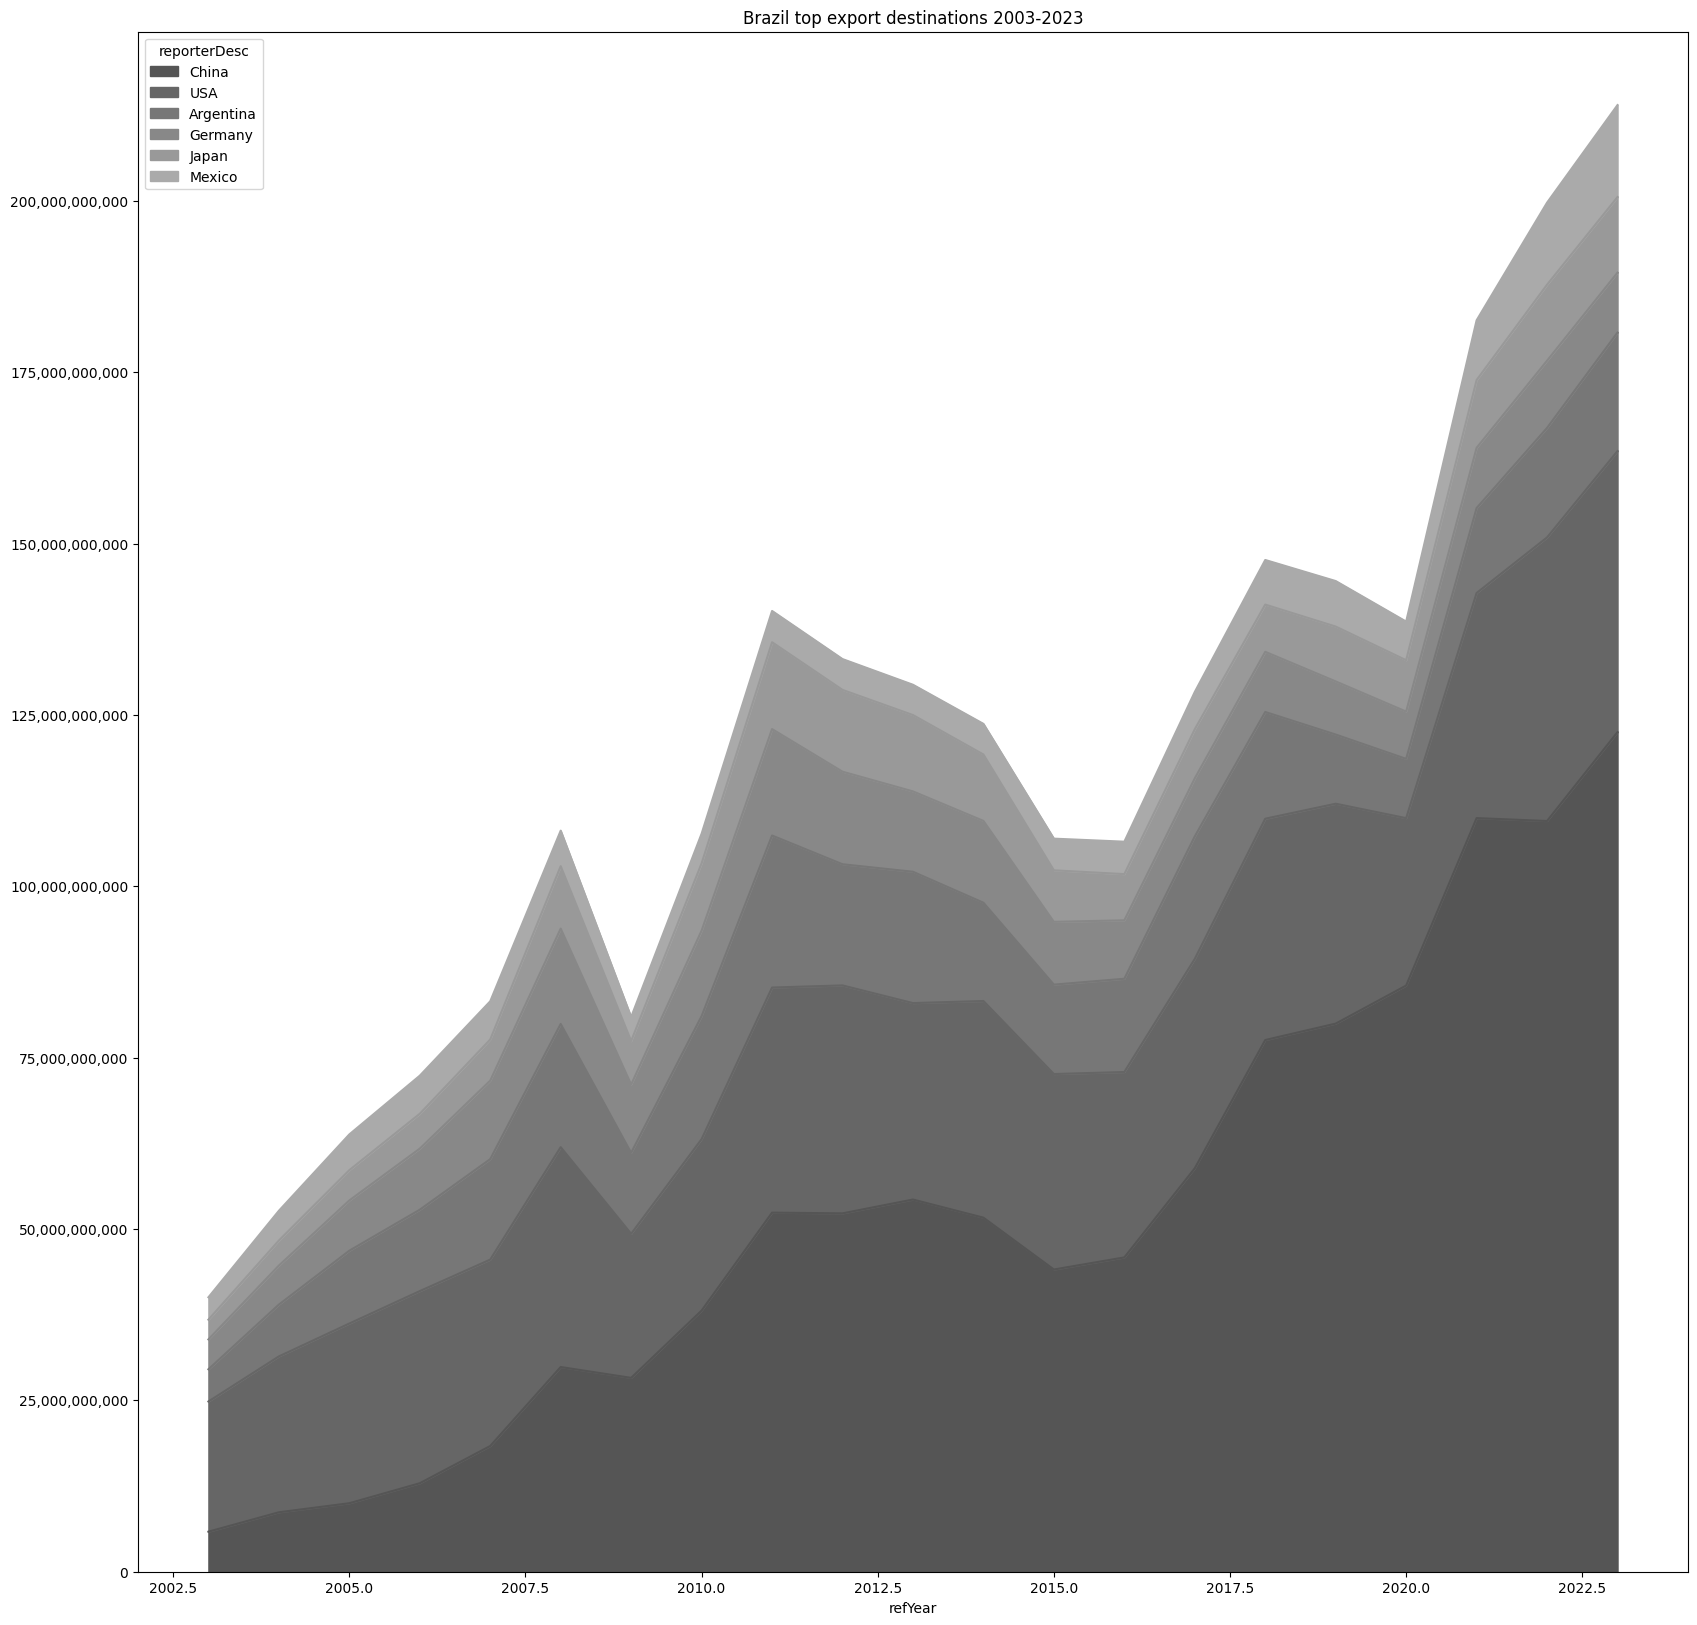

In [118]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plotfile = f"reports/{country_of_interest_name}_2.1.4_export_partners_{start_year}-{end_year}.png"
start_year=values_only.index.min()
end_year=values_only.index.max()
title=f"{country_of_interest_name} top export destinations {start_year}-{end_year}"
print("Plot saved to ", plotfile)
# see https://matplotlib.org/stable/gallery/color/named_colors.html
# colors = ['red','lightsalmon','green','lightgreen','darkviolet','violet','blue','dodgerblue','orange','yellow','brown','black','grey','pink','cyan','magenta',]
# colors = ['crimson', 'darkorange', 'gold', 'limegreen', 'mediumseagreen', 'teal', 'deepskyblue', 'royalblue', 'indigo', 'mediumvioletred', 'hotpink', 'saddlebrown', 'grey', 'black', 'darkslategrey', 'darkkhaki']
colors = [ '#555555', '#666666', '#777777', '#888888', '#999999', '#AAAAAA', '#BBBBBB', '#CCCCCC', ]

fig2 = values_only.plot.area(figsize=(20,20),title=title, color=colors)
for i, line in enumerate(fig2.get_lines()):
    n = i % len(colors)
    print(i, line, colors[n])
    line.set_color(colors[n])

formatter = ticker.StrMethodFormatter('{x:,.0f}')
fig2.yaxis.set_major_formatter(formatter)

plt.savefig(plotfile)
plt.show()

In [119]:
show_only_columns = [(l1, country) for l1,country in pivoted.columns.tolist() if country in top_export_partners]

#### Export to Excel

Table with the top export destinations for the period of interest

In [121]:
top_partners_file = f'reports/{country_of_interest_name}_2.1.1_top_export_partners.xlsx'
top_partners_cols_file = f'reports/{country_of_interest_name}_2.1.2_top_export_partners_cols.xlsx'
export_top_partners_file = f'reports/{country_of_interest_name}_2.1.3_export_top_{show_only_top}_partners_{start_year}-{end_year}.xlsx'

exports[cols].sort_values(['refYear','flowCode','partner_rank',f'{partner_column}Desc','cmdCode']).to_excel(top_partners_file)
pivoted.to_excel(top_partners_cols_file)
pivoted[show_only_columns].to_excel(export_top_partners_file)

print(f"Top partners file: {top_partners_file}")
print(f"Top partners cols file: {top_partners_cols_file}")
print(f"Export top partners file: {export_top_partners_file}")

Top partners file: reports/Brazil_2.1.1_top_export_partners.xlsx
Top partners cols file: reports/Brazil_2.1.2_top_export_partners_cols.xlsx
Export top partners file: reports/Brazil_2.1.3_export_top_5_partners_2003-2023.xlsx


### 2.2 Exports: products

#### What are the main exported products

In [93]:
import pandas as pd

# show 500 lines of dataframes
pd.set_option('display.max_rows', 500)

show_only_top=5
# years_of_interest = comtrade.year_range(2020, 2021)

print(country_of_interest_name, years_of_interest)

Brazil 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023


Get the products exported by country of interest

In [94]:

# If symmetric_reporting is "True" we get the exports from
#    the reported imports of all the countries
# i.e. instead of asking Country of Interest for export data we ask the world
#    for import data from Country of Interest

symmetric_reporting = True  # set to false to use reported exports by Country of Interest

if symmetric_reporting:
    reporterCode = None
    partnerCode = country_of_interest
    flowCode = 'M'
    reporter_column = 'partner'
    partner_column = 'reporter'
else:
    reporterCode = country_of_interest
    partnerCode = None
    flowCode = 'X'
    reporter_column = 'reporter'
    partner_column = 'partner'



In [95]:
import comtradetools

clCode = 'HS'
cmdDetail = 'AG6'  # AG2 aggregate two digits, top level, AG4 detail 4 digits, ... World Bank uses AG6
df = comtradetools.getFinalData(
                        APIKEY,
                        reporterCode=reporterCode,
                        typeCode='C',  # commodities
                        freqCode='A',  # annual
                        flowCode=flowCode,
                        period=years_of_interest,
                        period_size=1,
                        partnerCode=partnerCode,
                        remove_world=False,
                        partner2Code=0,
                        clCode=clCode,
                        cmdCode=cmdDetail,
                        motCode=0,  # all means of transport
                        customsCode='C00',
                        includeDesc=True,
                        cache=True
                        )

INFO:root:Calling getFinalData for period 2003
DEBUG:root:Call ('b5cdc1c0678544b0ab5085f7292e6643',){'reporterCode': None, 'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'M', 'period': '2003', 'partnerCode': 76, 'partner2Code': 0, 'clCode': 'HS', 'cmdCode': 'AG6', 'motCode': 0, 'customsCode': 'C00', 'includeDesc': True}False
INFO:root:Using cached results for period 2003
INFO:root:Calling getFinalData for period 2004
DEBUG:root:Call ('b5cdc1c0678544b0ab5085f7292e6643',){'reporterCode': None, 'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'M', 'period': '2004', 'partnerCode': 76, 'partner2Code': 0, 'clCode': 'HS', 'cmdCode': 'AG6', 'motCode': 0, 'customsCode': 'C00', 'includeDesc': True}False
INFO:root:Using cached results for period 2004
INFO:root:Calling getFinalData for period 2005
DEBUG:root:Call ('b5cdc1c0678544b0ab5085f7292e6643',){'reporterCode': None, 'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'M', 'period': '2005', 'partnerCode': 76, 'partner2Code': 0, 'clCode': 'HS', 'cmdCode

In [96]:
print("Years available in the data:", list(df.refYear.unique()))

Years available in the data: [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


In [97]:
df.head()

,typeCode,freqCode,refPeriodId,refYear,refMonth,period,reporterCode,reporterISO,reporterDesc,flowCode,...,netWgt,isNetWgtEstimated,grossWgt,isGrossWgtEstimated,cifvalue,fobvalue,primaryValue,legacyEstimationFlag,isReported,isAggregate
0,C,A,20030101,2003,52,2003,32,ARG,Argentina,M,...,"5,620.00",False,NaN,False,"23,692.00",NaN,"23,692.00",0,True,False
1,C,A,20030101,2003,52,2003,40,AUT,Austria,M,...,400.00,False,NaN,False,"4,633.00",NaN,"4,633.00",0,True,False
2,C,A,20030101,2003,52,2003,68,BOL,Bolivia (Plurinational State of),M,...,0.00,False,"14,400.00",False,"41,243.00","38,548.00","41,243.00",0,False,True
3,C,A,20030101,2003,52,2003,76,BRA,Brazil,M,...,"2,400.00",False,0.00,False,"27,245.00","13,644.00","27,245.00",0,False,True
4,C,A,20030101,2003,52,2003,32,ARG,Argentina,M,...,"1,000.00",False,NaN,False,"3,694.00",NaN,"3,694.00",0,True,False


Agreggate by product, keep the top products exported each year

In [99]:
import pandas as pd
import comtradetools
# show 500 lines
pd.options.display.max_rows=500
pd.options.display.float_format='{:,.2f}'.format

show_only_top = 5
exports = comtradetools.total_rank_perc(df,['refYear','flowCode','cmdCode'],'primaryValue','product',drop_duplicates=True)
exports = exports[exports['product_rank']<=show_only_top]
exports.info()

cols=['refYear','flowCode','product_rank','cmdCode', 'cmdDesc','product_sum','product_upper_perc', 'product_upper_sum']
formats =  comtradetools.make_format(cols)

top_export_products_codes = exports['cmdCode'].unique()

print(f"Top products exported by {country_of_interest_name} in {years_of_interest}:\n {top_export_products_codes}")
for cmdCode in top_export_products_codes:
    print(f"   {cmdCode}: {comtradetools.HS_CODES.get(cmdCode,cmdCode)}")
exports[cols].sort_values(['refYear','flowCode','product_rank']).head(10).style.format(formats)


<class 'pandas.core.frame.DataFrame'>
Index: 105 entries, 523 to 1972954
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   typeCode                  105 non-null    object 
 1   freqCode                  105 non-null    object 
 2   refPeriodId               105 non-null    int64  
 3   refYear                   105 non-null    int64  
 4   refMonth                  105 non-null    int64  
 5   period                    105 non-null    object 
 6   reporterCode              105 non-null    int64  
 7   reporterISO               105 non-null    object 
 8   reporterDesc              105 non-null    object 
 9   flowCode                  105 non-null    object 
 10  flowDesc                  105 non-null    object 
 11  partnerCode               105 non-null    int64  
 12  partnerISO                105 non-null    object 
 13  partnerDesc               105 non-null    object 
 14  partner2C

,refYear,flowCode,product_rank,cmdCode,cmdDesc,product_sum,product_upper_perc,product_upper_sum
523,2003,M,1,120100,Soya beans; whether or not broken,"$5,049,637,810",6.278%,"$80,428,079,360"
1226,2003,M,2,260111,Iron ores and concentrates; non-agglomerated,"$3,875,621,871",4.819%,"$80,428,079,360"
1052,2003,M,3,230400,"Oil-cake and other solid residues; whether or not ground or in the form of pellets, resulting from the extraction of soya-bean oil","$3,061,242,818",3.806%,"$80,428,079,360"
9662,2003,M,4,870323,"Vehicles; spark-ignition internal combustion reciprocating piston engine, cylinder capacity exceeding 1500cc but not exceeding 3000cc","$2,335,262,747",2.904%,"$80,428,079,360"
1261,2003,M,5,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude","$2,050,862,180",2.550%,"$80,428,079,360"
86314,2004,M,1,120100,Soya beans; whether or not broken,"$6,340,840,699",5.993%,"$105,809,660,060"
87054,2004,M,2,260111,Iron ores and concentrates; non-agglomerated,"$6,278,346,824",5.934%,"$105,809,660,060"
86876,2004,M,3,230400,"Oil-cake and other solid residues; whether or not ground or in the form of pellets, resulting from the extraction of soya-bean oil","$3,733,412,128",3.528%,"$105,809,660,060"
87096,2004,M,4,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude","$2,700,444,964",2.552%,"$105,809,660,060"
96317,2004,M,5,870323,"Vehicles; spark-ignition internal combustion reciprocating piston engine, cylinder capacity exceeding 1500cc but not exceeding 3000cc","$2,544,325,740",2.405%,"$105,809,660,060"


#### Export to Excel

In [100]:
filename = f'reports/{country_of_interest_name}_2.2_exports_products_{clCode}-{cmdDetail}-{exports["refYear"].min()}-{exports["refYear"].max()}.xlsx'
print("Exporting to ",filename)
exports[cols].sort_values(['refYear','flowCode','product_rank']).to_excel(filename,index=False)

Exporting to  reports/Brazil_2.2_exports_products_HS-AG6-2003-2023.xlsx


### 2.3 Export partners / products analysis

Which are the partners buying the top exports of country of interest?


In [101]:

# If symmetric_reporting is "True" we get the exports from
#    the reported imports of all the countries
# i.e. instead of asking Country of Interest for export data we ask the world
#    for import data from Country of Interest

symmetric_reporting = True  # set to false to use reported exports by Country of Interest

if symmetric_reporting:
    reporterCode = None
    partnerCode = country_of_interest
    flowCode = 'M'
    reporter_column = 'partner'
    partner_column = 'reporter'
else:
    reporterCode = country_of_interest
    partnerCode = None
    flowCode = 'X'
    reporter_column = 'reporter'
    partner_column = 'partner'



In [102]:
import warnings
warnings.filterwarnings('default')

clCode = 'HS'
cmdDetail = 'AG6'  # not all countries report at higher detail

df = comtradetools.getFinalData(
                        APIKEY,
                        reporterCode=reporterCode,
                        typeCode='C',  # commodities
                        freqCode='A',  # annual
                        flowCode=flowCode,
                        period=years_of_interest,
                        period_size=1,
                        partnerCode=partnerCode,
                        remove_world=True,
                        partner2Code=0,
                        clCode=clCode,
                        cmdCode=cmdDetail,
                        motCode=0,  # all means of transport
                        customsCode='C00',
                        includeDesc=True,
                        cache=True
                        )
df.info()

INFO:root:Calling getFinalData for period 2003
DEBUG:root:Call ('b5cdc1c0678544b0ab5085f7292e6643',){'reporterCode': None, 'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'M', 'period': '2003', 'partnerCode': 76, 'partner2Code': 0, 'clCode': 'HS', 'cmdCode': 'AG6', 'motCode': 0, 'customsCode': 'C00', 'includeDesc': True}False
INFO:root:Using cached results for period 2003
INFO:root:Calling getFinalData for period 2004
DEBUG:root:Call ('b5cdc1c0678544b0ab5085f7292e6643',){'reporterCode': None, 'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'M', 'period': '2004', 'partnerCode': 76, 'partner2Code': 0, 'clCode': 'HS', 'cmdCode': 'AG6', 'motCode': 0, 'customsCode': 'C00', 'includeDesc': True}False
INFO:root:Using cached results for period 2004
INFO:root:Calling getFinalData for period 2005
DEBUG:root:Call ('b5cdc1c0678544b0ab5085f7292e6643',){'reporterCode': None, 'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'M', 'period': '2005', 'partnerCode': 76, 'partner2Code': 0, 'clCode': 'HS', 'cmdCode

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2041673 entries, 0 to 2041672
Data columns (total 47 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   typeCode                  object 
 1   freqCode                  object 
 2   refPeriodId               int64  
 3   refYear                   int64  
 4   refMonth                  int64  
 5   period                    object 
 6   reporterCode              int64  
 7   reporterISO               object 
 8   reporterDesc              object 
 9   flowCode                  object 
 10  flowDesc                  object 
 11  partnerCode               int64  
 12  partnerISO                object 
 13  partnerDesc               object 
 14  partner2Code              int64  
 15  partner2ISO               object 
 16  partner2Desc              object 
 17  classificationCode        object 
 18  classificationSearchCode  object 
 19  isOriginalClassification  bool   
 20  cmdCode                 

In [104]:
cols=['refYear','flowCode','reporterDesc','partnerDesc','primaryValue','cmdCode','cmdDesc']
df[cols].sample(10)

,refYear,flowCode,reporterDesc,partnerDesc,primaryValue,cmdCode,cmdDesc
1705088,2020,M,Lebanon,Brazil,"9,768.00",020621,"Offal, edible; of bovine animals, tongues, frozen"
295573,2006,M,Canada,Brazil,"161,792.00",611020,"Jerseys, pullovers, cardigans, waistcoats and ..."
174147,2004,M,Venezuela,Brazil,"3,827.00",842091,"Machines; parts, cylinders for calendering or ..."
1187882,2015,M,Chile,Brazil,"188,209.20",841981,"Machinery, plant and equipment; for making hot..."
588514,2009,M,Angola,Brazil,"2,333,497.00",870421,Vehicles; compression-ignition internal combus...
1198158,2015,M,France,Brazil,"1,691.00",851810,Microphones and stands therefor
424626,2007,M,Malta,Brazil,235.00,482190,"Paper and paperboard; labels of all kinds, unp..."
520282,2008,M,Italy,Brazil,"10,724.75",480300,"Tissue, towel, napkin stock or similar; for ho..."
1453097,2017,M,Sudan,Brazil,"572,332.00",843149,"Machinery; parts of machines handling earth, m..."
42410,2003,M,Italy,Brazil,774.62,560900,"Yarn; articles of yarn, strip or the like of h..."


In [89]:
df.refYear.unique()

array([2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])

Aggregate by partner and keep the main ones

In [105]:
import pandas as pd
import comtradetools
import warnings

# show 500 lines
pd.options.display.max_rows=500
pd.options.display.float_format='{:,.2f}'.format

show_only_top = 5
print(f"Top products exported by {country_of_interest_name} in {years_of_interest}:\n {top_export_products_codes}")
for cmdCode in top_export_products_codes:
    print(f"   {cmdCode}: {comtradetools.HS_CODES.get(cmdCode,cmdCode)}")

print(f"Top export partners ({len(top_export_partners)}): {top_export_partners}")
prefix='cmd_partner'
# remove world
if 0 in df[f'{partner_column}Code'].unique():
    warnings.warn("Removing world from data")
    df = df[df[f'{partner_column}Code']!=0]

products_and_partners = comtradetools.total_rank_perc(df,['refYear','flowCode','cmdCode',f'{partner_column}Code'],'primaryValue',prefix,drop_duplicates=True)

cols=['refYear','flowCode','cmdCode','cmdDesc',f'{partner_column}Desc',f'{prefix}_rank',f'{prefix}_sum',f'{prefix}_perc',f'{prefix}_upper_sum']
formats=comtradetools.make_format(cols)
products_and_partners=products_and_partners[(products_and_partners['cmdCode'].isin(top_export_products_codes)
                       & (products_and_partners[f'{prefix}_rank']<=show_only_top))]


Top products exported by Brazil in 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023:
 ['120100' '230400' '260111' '270900' '870323' '170111' '260112' '470329'
 '120190' '100590' '170114' '020230' '999999']
   120100: 120100
   230400: Oil-cake and other solid residues; whether or not ground or in the form of pellets, resulting from the extraction of soya-bean oil
   260111: Iron ores and concentrates; non-agglomerated
   270900: Oils; petroleum oils and oils obtained from bituminous minerals, crude
   870323: Vehicles; with only spark-ignition internal combustion reciprocating piston engine, cylinder capacity over 1500 but not over 3000cc
   170111: 170111
   260112: Iron ores and concentrates; agglomerated (excluding roasted iron pyrites)
   470329: Wood pulp; chemical wood pulp, soda or sulphate, (other than dissolving grades), semi-bleached or bleached, of non-coniferous wood
   120190: Soya beans; other than seed, whether or n

#### Show partners for main export products

In [91]:
products_and_partners[cols].sort_values(['refYear','flowCode',f'{prefix}_upper_sum',f'{prefix}_rank'],
                                             ascending=[True,True,False,True])\
                                             .head(10).style.format(formats) #.hide(axis='index')

,refYear,flowCode,cmdCode,cmdDesc,reporterDesc,cmd_partner_rank,cmd_partner_sum,cmd_partner_perc,cmd_partner_upper_sum
11385,2003,M,120100,Soya beans; whether or not broken,China,1,"$1,683,314,880",33.335%,"$5,049,637,810"
50150,2003,M,120100,Soya beans; whether or not broken,Netherlands,2,"$704,040,674",13.942%,"$5,049,637,810"
32534,2003,M,120100,Soya beans; whether or not broken,Germany,3,"$499,056,000",9.883%,"$5,049,637,810"
69541,2003,M,120100,Soya beans; whether or not broken,Spain,4,"$368,141,908",7.290%,"$5,049,637,810"
38592,2003,M,120100,Soya beans; whether or not broken,Japan,5,"$234,071,083",4.635%,"$5,049,637,810"
12290,2003,M,260111,Iron ores and concentrates; non-agglomerated,China,1,"$1,004,243,700",25.912%,"$3,875,621,871"
39431,2003,M,260111,Iron ores and concentrates; non-agglomerated,Japan,2,"$598,630,020",15.446%,"$3,875,621,871"
32866,2003,M,260111,Iron ores and concentrates; non-agglomerated,Germany,3,"$413,811,000",10.677%,"$3,875,621,871"
26739,2003,M,260111,Iron ores and concentrates; non-agglomerated,France,4,"$313,666,979",8.093%,"$3,875,621,871"
39432,2003,M,260111,Iron ores and concentrates; non-agglomerated,Rep. of Korea,5,"$270,484,562",6.979%,"$3,875,621,871"


#### Export to Excel

In [106]:
filename = f'reports/{country_of_interest_name}_2.3_exports_products_partners_{clCode}-{cmdDetail}-{products_and_partners["refYear"].min()}-{products_and_partners["refYear"].max()}.xlsx'
products_and_partners[cols].sort_values(['refYear','flowCode',f'{prefix}_upper_sum',f'{prefix}_rank'],
                                             ascending=[True,True,False,True]).to_excel(filename, index=False)
print("Exporting to ",filename)

Exporting to  reports/Brazil_2.3_exports_products_partners_HS-AG6-2003-2023.xlsx


### 2.4 Main clients and products exported 

Detail of the main products by export partner.

Allows to analyse the mix of products of the main export partners from this country

In [107]:
top_export_partners

array(['Argentina', 'China', 'Germany', 'Mexico', 'USA', 'Japan'],
      dtype=object)

In [108]:
import comtradetools

show_only_top = 5

print(f"Top export partners ({len(top_export_partners)}): {top_export_partners}")
prefix='partner_cmd'
partners_and_products = comtradetools.total_rank_perc(df,['refYear','flowCode',f'{partner_column}Code','cmdCode'],'primaryValue',prefix,drop_duplicates=False)

cols=['refYear','flowCode',f'{partner_column}Desc','cmdCode','cmdDesc',f'{prefix}_rank',f'{prefix}_sum',f'{prefix}_perc',f'{prefix}_upper_sum']
formats = comtradetools.make_format(cols)
partners_and_products=partners_and_products[(partners_and_products[f'{partner_column}Desc'].isin(top_export_partners)
                       & (partners_and_products[f'{prefix}_rank']<=show_only_top))]

print("First rows")
partners_and_products[partners_and_products[f'{prefix}_rank']<=show_only_top][cols].sort_values(
    ['refYear','flowCode','partner_cmd_upper_sum',f'{prefix}_sum',f'{prefix}_rank'],
    ascending=[True,True,False,False,False]).head(10).style.format(formats).hide(axis='index')

Top export partners (6): ['Argentina' 'China' 'Germany' 'Mexico' 'USA' 'Japan']
First rows


refYear,flowCode,reporterDesc,cmdCode,cmdDesc,partner_cmd_rank,partner_cmd_sum,partner_cmd_perc,partner_cmd_upper_sum
2003,M,USA,880230,"Aeroplanes and other aircraft; of an unladen weight exceeding 2000kg but not exceeding 15,000kg",1,"$1,836,276,910",9.669%,"$18,991,824,510"
2003,M,USA,852520,"Transmission apparatus; for radio-telephony, radio-telegraphy, radio-broadcasting or television, with reception apparatus, with or without sound recording or reproducing apparatus",2,"$943,115,480",4.966%,"$18,991,824,510"
2003,M,USA,999999,Commodities not specified according to kind,3,"$880,830,985",4.638%,"$18,991,824,510"
2003,M,USA,271019,"Oils; petroleum oils and oils obtained from bituminous minerals, not crude; preparations n.e.c., containing by weight 70% or more of petroleum oils or oils obtained from bituminous minerals, (excluding waste oils), other than light oils and preparations",4,"$831,698,230",4.379%,"$18,991,824,510"
2003,M,USA,640399,"Footwear; n.e.s. in heading no. 6403, (not covering the ankle), outer soles of rubber, plastics or composition leather, uppers of leather",5,"$796,349,455",4.193%,"$18,991,824,510"
2003,M,China,120100,Soya beans; whether or not broken,1,"$1,683,314,880",28.813%,"$5,842,291,688"
2003,M,China,260111,Iron ores and concentrates; non-agglomerated,2,"$1,004,243,700",17.189%,"$5,842,291,688"
2003,M,China,260112,Iron ores and concentrates; agglomerated (excluding roasted iron pyrites),3,"$343,389,832",5.878%,"$5,842,291,688"
2003,M,China,470329,"Wood pulp; chemical wood pulp, soda or sulphate, (other than dissolving grades), semi-bleached or bleached, of non-coniferous wood",4,"$270,472,023",4.630%,"$5,842,291,688"
2003,M,China,150710,"Vegetable oils; soya-bean oil and its fractions, crude, whether or not degummed, not chemically modified",5,"$237,516,693",4.065%,"$5,842,291,688"


Last rows

In [109]:
partners_and_products[partners_and_products[f'{prefix}_rank']<=show_only_top][cols].sort_values(
    ['refYear','flowCode','partner_cmd_upper_sum',f'{prefix}_sum',f'{prefix}_rank'],
    ascending=[True,True,False,False,False]).tail(10).style.format(formats).hide(axis='index')

refYear,flowCode,reporterDesc,cmdCode,cmdDesc,partner_cmd_rank,partner_cmd_sum,partner_cmd_perc,partner_cmd_upper_sum
2023,M,Japan,260111,Iron ores and concentrates; non-agglomerated,1,"$2,964,684,527",26.886%,"$11,026,999,417"
2023,M,Japan,100590,"Cereals; maize (corn), other than seed",2,"$2,092,442,294",18.976%,"$11,026,999,417"
2023,M,Japan,260112,Iron ores and concentrates; agglomerated (excluding roasted iron pyrites),3,"$1,041,477,567",9.445%,"$11,026,999,417"
2023,M,Japan,020714,"Meat and edible offal; of fowls of the species Gallus domesticus, cuts and offal, frozen",4,"$860,362,470",7.802%,"$11,026,999,417"
2023,M,Japan,220710,Undenatured ethyl alcohol; of an alcoholic strength by volume of 80% vol. or higher,5,"$563,103,032",5.107%,"$11,026,999,417"
2023,M,Germany,090111,Coffee; not roasted or decaffeinated,1,"$1,178,280,289",13.481%,"$8,740,362,863"
2023,M,Germany,260300,Copper ores and concentrates,2,"$952,478,115",10.897%,"$8,740,362,863"
2023,M,Germany,230400,"Oil-cake and other solid residues; whether or not ground or in the form of pellets, resulting from the extraction of soya-bean oil",3,"$678,013,144",7.757%,"$8,740,362,863"
2023,M,Germany,260111,Iron ores and concentrates; non-agglomerated,4,"$641,276,860",7.337%,"$8,740,362,863"
2023,M,Germany,470329,"Wood pulp; chemical wood pulp, soda or sulphate, (other than dissolving grades), semi-bleached or bleached, of non-coniferous wood",5,"$551,339,460",6.308%,"$8,740,362,863"


In [110]:
filename = f'reports/{country_of_interest_name}_2.4_exports_partners_products_{clCode}-{cmdDetail}-{partners_and_products["refYear"].min()}-{partners_and_products["refYear"].max()}.xlsx'
partners_and_products[partners_and_products[f'{prefix}_rank']<=show_only_top][cols].sort_values(
    ['refYear','flowCode','partner_cmd_upper_sum',f'{prefix}_sum',f'{prefix}_rank'],
    ascending=[True,True,False,False,False])[cols].to_excel(filename, index=False)
print("Exporting to ",filename)

Exporting to  reports/Brazil_2.4_exports_partners_products_HS-AG6-2003-2023.xlsx


### 2.5 Alternative suppliers of costumers of country of interest




For each year, partner, exported commodity, fetches all the imports of
the commodity by partner from other countries, and computes the ranking
of country of interest among the suppliers of partner for that commodity,
e.g.

Country of interest：Angola, in 2021, China, exported commodity code 270900 "Oils; petroleum oils and oils obtained 
from bituminous minerals, crude" ; fetch all suppliers of 270900 of China and compute
the ranking of Angola.


First step is to get the combos of partner and commodity

In [49]:
combos_of_interest = partners_and_products[(partners_and_products['cmdCode'].isin(top_export_products_codes)
                & (partners_and_products[f'{partner_column}Code'].isin(top_export_partners_codes)))][[f'{partner_column}Code','cmdCode']].drop_duplicates()
combos_of_interest = [tuple(x) for x in combos_of_interest.values]
len(combos_of_interest)

34

In [50]:
# create lists of commodities codes and country codes to query comtrade
cmdCode_list = [cmdCode for (countryCode,cmdCode) in combos_of_interest]
cmdCode_list = list(set(cmdCode_list))
countryCode_list = [countryCode for (countryCode,cmdCode) in combos_of_interest]
countryCode_list = list(set(countryCode_list))
cmdCodeCSV = ','.join(cmdCode_list)
countryCodeCSV = ','.join(map(str,countryCode_list))

Get all the suppliers of client for products exported by contry of interest.

In [51]:
print("Years of interest: ", years_of_interest)
print("countryCodeCSV: ", countryCodeCSV)
print("cmdCodeCSV: ", cmdCodeCSV)

df = comtradetools.getFinalData(APIKEY,
                                typeCode='C',  # commodities
                                freqCode='A',  # annual
                                flowCode='M',
                                reporterCode=countryCodeCSV,
                                partnerCode=None,
                                remove_world=True,
                                partner2Code=0,
                                period=years_of_interest,
                                period_size=1,
                                clCode=clCode,
                                cmdCode=cmdCodeCSV,  # Top level product types
                                motCode=0,  # all means of transport
                                customsCode='C00',
                                includeDesc=True,
                                cache=True,

                                )

Years of interest:  2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
countryCodeCSV:  32,484,392,842,276,156
cmdCodeCSV:  100590,120100,120190,870323,170114,230400,999999,020230,260111,270900,260112,470329
INFO:root:Calling getFinalData for period 2003
DEBUG:root:Call ('b5cdc1c0678544b0ab5085f7292e6643',){'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'M', 'reporterCode': '32,484,392,842,276,156', 'partnerCode': None, 'partner2Code': 0, 'period': '2003', 'clCode': 'HS', 'cmdCode': '100590,120100,120190,870323,170114,230400,999999,020230,260111,270900,260112,470329', 'motCode': 0, 'customsCode': 'C00', 'includeDesc': True}False
INFO:root:Using cached results for period 2003
INFO:root:Calling getFinalData for period 2004
DEBUG:root:Call ('b5cdc1c0678544b0ab5085f7292e6643',){'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'M', 'reporterCode': '32,484,392,842,276,156', 'partnerCode': None, 'partner2Code': 0, 'period': '2004', 'clCode': '

/Users/jrc/develop/cipf-comtrade/comtradetools.py:652: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, temp], ignore_index=True)
/Users/jrc/develop/cipf-comtrade/comtradetools.py:652: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, temp], ignore_index=True)
/Users/jrc/develop/cipf-comtrade/comtradetools.py:652: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude emp

Alternative, concatenating

In [299]:
import pandas as pd

try_alternative = False

if try_alternative:
    df2: pd.DataFrame = None
    for countryCode,cmdCode in combos_of_interest:
        print(countryCode,cmdCode)
        tmp = comtradetools.getFinalData(APIKEY,
                                        reporterCode=countryCode,
                                        typeCode='C',  # commodities
                                        freqCode='A',  # annual
                                        flowCode='M',
                                        partnerCode=None,
                                        remove_world=True,
                                        partner2Code=0,
                                        period=years_of_interest,
                                        period_size=6,
                                        clCode='HS',
                                        cmdCode=cmdCode,  # Top level product types
                                        customsCode='C00',
                                        motCode=0,  # all means of transport
                                        )
        if df2 is None:
            df2 = tmp
        else:
            df2 = pd.concat([df2,tmp],axis=0)


Partners buying top products of country of interest.

In [52]:
list(df.reporterDesc.unique()), list(df.partnerDesc.unique())


(['Argentina', 'China', 'Germany', 'Mexico', 'Japan', 'USA'],
 ['Spain',
  'Germany',
  'Japan',
  'Areas, nes',
  'France',
  'Rep. of Korea',
  'United Kingdom',
  'Austria',
  'Belgium',
  'Mexico',
  'Netherlands',
  'Portugal',
  'Slovakia',
  'Sweden',
  'Italy',
  'Brazil',
  'USA',
  'Hungary',
  'Bolivia (Plurinational State of)',
  'Ghana',
  'Nigeria',
  'Peru',
  'Paraguay',
  'Canada',
  'Uruguay',
  'Chile',
  'Norway',
  'Viet Nam',
  'Russian Federation',
  'South Africa',
  'New Zealand',
  'Philippines',
  'Finland',
  'India',
  'Indonesia',
  'Malaysia',
  'Thailand',
  'Australia',
  'China, Hong Kong SAR',
  'Other Asia, nes',
  'Belarus',
  'Greece',
  'Iran',
  'Israel',
  'Singapore',
  'Switzerland',
  'Ukraine',
  'China',
  'Egypt',
  'Romania',
  'Türkiye',
  'Czechia',
  'Poland',
  'Angola',
  'Azerbaijan',
  'Algeria',
  'Brunei Darussalam',
  'Cameroon',
  'Congo',
  'Ecuador',
  'Equatorial Guinea',
  'Gabon',
  'Kuwait',
  'Libya',
  'Oman',
  'Panama

For each partner show the top supliers of the products bought from country of interest. 

If country of interest is not in the top five, show position anyway if it is a supplier in the given year 

In [53]:
import pandas as pd
import comtradetools

#  set max rows to 500
pd.set_option('display.max_rows', 1500)


other_suppliers = comtradetools.total_rank_perc(
                                        df,
                                        groupby=['refYear','flowCode','reporterCode','cmdCode','partnerCode'],
                                        col='primaryValue',
                                        prefix='cmd_partner',
                                        )

other_suppliers = other_suppliers[other_suppliers[['reporterCode','cmdCode']].apply(tuple,axis=1).isin(combos_of_interest)]
cols=['reporterDesc','flowCode','refYear','cmdCode','cmdDesc','cmd_partner_rank','partnerDesc','primaryValue','cmd_partner_perc','cmd_partner_upper_sum']
formats =  comtradetools.make_format(cols)

other_suppliers[(other_suppliers['partnerCode'] == country_of_interest)
                | (other_suppliers['cmd_partner_rank']<=show_only_top)
                ][cols].sort_values(by=['reporterDesc','cmdCode','refYear','cmd_partner_rank']).head(20).style.format(formats).hide(axis="index")

reporterDesc,flowCode,refYear,cmdCode,cmdDesc,cmd_partner_rank,partnerDesc,primaryValue,cmd_partner_perc,cmd_partner_upper_sum
Argentina,M,2012,120190,"Soya beans; other than seed, whether or not broken",1,USA,$702,100.000%,$702
Argentina,M,2013,120190,"Soya beans; other than seed, whether or not broken",1,Brazil,"$741,418",83.590%,"$886,966"
Argentina,M,2013,120190,"Soya beans; other than seed, whether or not broken",2,Argentina,"$145,491",16.403%,"$886,966"
Argentina,M,2013,120190,"Soya beans; other than seed, whether or not broken",3,USA,$57,0.006%,"$886,966"
Argentina,M,2014,120190,"Soya beans; other than seed, whether or not broken",1,Brazil,"$157,735",100.000%,"$157,735"
Argentina,M,2015,120190,"Soya beans; other than seed, whether or not broken",1,Argentina,"$69,103",99.913%,"$69,163"
Argentina,M,2015,120190,"Soya beans; other than seed, whether or not broken",2,USA,$60,0.087%,"$69,163"
Argentina,M,2016,120190,"Soya beans; other than seed, whether or not broken",1,Paraguay,"$256,401,308",79.886%,"$320,957,417"
Argentina,M,2016,120190,"Soya beans; other than seed, whether or not broken",2,Uruguay,"$49,292,895",15.358%,"$320,957,417"
Argentina,M,2016,120190,"Soya beans; other than seed, whether or not broken",3,Bolivia (Plurinational State of),"$8,434,909",2.628%,"$320,957,417"


### Ranking of country of interest in the supliers of main export products

Allows assessment of the importance of country of interest for the partners
that are buying its main exports.

In [54]:
ignore_if_rank_is_higher = 25

relevant_for_partner_imports=other_suppliers[
    (other_suppliers['partnerCode'
                     ] == country_of_interest) &
    (other_suppliers['cmd_partner_rank'] < ignore_if_rank_is_higher)

                     ][cols].sort_values(by=['reporterDesc','cmdCode','refYear','cmd_partner_rank'])
relevant_for_partner_imports.head(50).style.format(formats).hide(axis='index')

reporterDesc,flowCode,refYear,cmdCode,cmdDesc,cmd_partner_rank,partnerDesc,primaryValue,cmd_partner_perc,cmd_partner_upper_sum
Argentina,M,2013,120190,"Soya beans; other than seed, whether or not broken",1,Brazil,"$741,418",83.590%,"$886,966"
Argentina,M,2014,120190,"Soya beans; other than seed, whether or not broken",1,Brazil,"$157,735",100.000%,"$157,735"
Argentina,M,2016,120190,"Soya beans; other than seed, whether or not broken",4,Brazil,"$6,800,669",2.119%,"$320,957,417"
Argentina,M,2017,120190,"Soya beans; other than seed, whether or not broken",2,Brazil,"$66,156,555",9.453%,"$699,830,590"
Argentina,M,2018,120190,"Soya beans; other than seed, whether or not broken",3,Brazil,"$257,178,057",10.271%,"$2,503,811,695"
Argentina,M,2019,120190,"Soya beans; other than seed, whether or not broken",3,Brazil,"$135,937,103",8.477%,"$1,603,521,281"
Argentina,M,2020,120190,"Soya beans; other than seed, whether or not broken",2,Brazil,"$140,270,206",7.091%,"$1,978,143,490"
Argentina,M,2021,120190,"Soya beans; other than seed, whether or not broken",2,Brazil,"$119,487,083",4.560%,"$2,620,298,902"
Argentina,M,2022,120190,"Soya beans; other than seed, whether or not broken",4,Brazil,"$193,658,674",9.142%,"$2,118,309,342"
Argentina,M,2023,120190,"Soya beans; other than seed, whether or not broken",2,Brazil,"$2,179,717,729",38.796%,"$5,618,397,309"


In [55]:
filename = f'reports/{country_of_interest_name}_2.5.1_export_partners_alternative.xlsx'
print("Exporting to ",filename)
other_suppliers[cols].sort_values(by=['reporterDesc','cmdCode','refYear','cmd_partner_rank']).to_excel(filename)

Exporting to  reports/Brazil_2.5.1_export_partners_alternative.xlsx


In [56]:
filename = f'reports/{country_of_interest_name}_2.5.2_export_partners_alternative_relevant.xlsx'
print("Exporting to ",filename)
relevant_for_partner_imports.to_excel(filename)

Exporting to  reports/Brazil_2.5.2_export_partners_alternative_relevant.xlsx


## 3. Imports

In [122]:
print(country_of_interest_name, years_of_interest)

Brazil 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023


### 3.1 Main import partners

Collect imports to country of interest.

Use either reported imports by country of interest, 
or reported exports to country of interest by
all other countries (symmetric reporting). 

Set variable `symmetric_reporting` to choose.

In [123]:
# If symmetric_reporting is "True" we get the imports from
#    the reported exports of all the countries
# i.e. instead of asking Country of Interest for import data we ask the world
#    for export data towards Country of Interest

symmetric_reporting = False  # set to false to use reported imports by Country of Interest

if symmetric_reporting:
    reporterCode = None
    partnerCode = country_of_interest
    flowCode = 'X'
    reporter_column = 'partner'
    partner_column = 'reporter'
else:
    reporterCode = country_of_interest
    partnerCode = None
    flowCode = 'M'
    reporter_column = 'reporter'
    partner_column = 'partner'



In [124]:
clCode = 'HS'
cmdDetail = 'AG6'  # AG2 aggregate two digits, top level, AG4 detail 4 digits, ... World bank uses AG6, but some codes AG4
df = comtradetools.getFinalData(
                        APIKEY,
                        reporterCode=reporterCode,
                        typeCode='C',  # commodities
                        freqCode='A',  # annual
                        flowCode=flowCode,  # imports
                        partnerCode=partnerCode, # every body
                        remove_world=True,
                        partner2Code=0, # ignore parter2
                        period=years_of_interest,
                        period_size=1,
                        clCode="HS",
                        cmdCode="TOTAL",
                        motCode=0,  # all means of transport
                        customsCode='C00',
                        includeDesc=True,
                        cache=True
                        )

INFO:root:Calling getFinalData for period 2003
DEBUG:root:Call ('b5cdc1c0678544b0ab5085f7292e6643',){'reporterCode': 76, 'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'M', 'partnerCode': None, 'partner2Code': 0, 'period': '2003', 'clCode': 'HS', 'cmdCode': 'TOTAL', 'motCode': 0, 'customsCode': 'C00', 'includeDesc': True}False
INFO:root:Using cached results for period 2003
INFO:root:Calling getFinalData for period 2004
DEBUG:root:Call ('b5cdc1c0678544b0ab5085f7292e6643',){'reporterCode': 76, 'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'M', 'partnerCode': None, 'partner2Code': 0, 'period': '2004', 'clCode': 'HS', 'cmdCode': 'TOTAL', 'motCode': 0, 'customsCode': 'C00', 'includeDesc': True}False
INFO:root:Using cached results for period 2004
INFO:root:Calling getFinalData for period 2005
DEBUG:root:Call ('b5cdc1c0678544b0ab5085f7292e6643',){'reporterCode': 76, 'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'M', 'partnerCode': None, 'partner2Code': 0, 'period': '2005', 'clCode': 'HS', 'cmd

Compute percentage of trade and rank of partners for each year.

Use `show_only_top` to show only the top partners (e.g. 5).

In [126]:
import pandas as pd
import comtradetools
# show 500 lines
pd.options.display.max_rows=500
pd.options.display.float_format='{:,.2f}'.format

show_only_top = 5
partner_column = 'partner'
reporter_column = 'reporter'

# aggregate by year, flow, reporter
imports = comtradetools.total_rank_perc(df,groupby=['refYear','flowCode',f'{partner_column}Desc'],
                                    col='primaryValue',
                                    prefix='partner',
                                    drop_duplicates=True)

cols=['refYear','flowCode','partner_rank',f'{partner_column}Desc','partner_sum','partner_perc','partner_upper_perc']

formats =  comtradetools.make_format(cols)

top_import_partners = imports[imports['partner_rank']<=show_only_top][f'{partner_column}Desc'].unique()
top_import_partners_codes = imports[imports['partner_rank']<=show_only_top][f'{partner_column}Code'].unique()

print(f"Top {show_only_top} import partners of {country_of_interest_name} in {years_of_interest}: \n{top_import_partners}")
imports[imports['partner_rank']<=show_only_top][cols].sort_values(['refYear','flowCode','partner_rank']).style.format(formats)

Top 5 import partners of Brazil in 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023: 
['Argentina' 'China' 'Japan' 'USA' 'Germany' 'Nigeria' 'Rep. of Korea'
 'Mexico' 'India' 'Russian Federation']


,refYear,flowCode,partner_rank,partnerDesc,partner_sum,partner_perc,partner_upper_perc
94,2003,M,1,USA,"$10,175,264,493",19.618%,19.618%
2,2003,M,2,Argentina,"$4,949,242,272",9.542%,9.542%
154,2003,M,3,Germany,"$4,368,470,447",8.422%,8.422%
78,2003,M,4,Japan,"$2,631,008,260",5.073%,5.073%
20,2003,M,5,China,"$2,326,252,397",4.485%,4.485%
371,2004,M,1,USA,"$12,079,317,107",17.906%,17.906%
193,2004,M,2,Argentina,"$5,902,965,620",8.750%,8.750%
250,2004,M,3,Germany,"$5,284,809,107",7.834%,7.834%
222,2004,M,4,China,"$4,047,080,318",5.999%,5.999%
312,2004,M,5,Nigeria,"$3,567,388,109",5.288%,5.288%


Pivot the countries to columns, keeping the total value and percentage in separate columns.

----

Passamos os países para colunas, mantendo a percentagem e o valor em separado.

In [127]:
pivoted = df.pivot_table(index=['refYear','flowDesc'], columns=f'{partner_column}Desc', values=['primaryValue','partner_perc'])
pivoted.swaplevel(axis=1).fillna(0,inplace=True)
pivoted.sort_index(axis=1, level=0, inplace=True)
pivoted.fillna(0, inplace=True)
pivoted

partner_perc                                                \
partnerDesc       Afghanistan Albania Algeria American Samoa Andorra Angola   
refYear flowDesc                                                              
2003    Import           0.00    0.00    0.02           0.00    0.00   0.00   
2004    Import           0.00    0.00    0.03           0.00    0.00   0.00   
2005    Import           0.00    0.00    0.04           0.00    0.00   0.00   
2006    Import           0.00    0.00    0.02           0.00    0.00   0.00   
2007    Import           0.00    0.00    0.02           0.00    0.00   0.01   
2008    Import           0.00    0.00    0.01           0.00    0.00   0.01   
2009    Import           0.00    0.00    0.01           0.00    0.00   0.00   
2010    Import           0.00    0.00    0.01           0.00    0.00   0.00   
2011    Import           0.00    0.00    0.01           0.00    0.00   0.00   
2012    Import           0.00    0.00    0.01           0.00    0.00   0.00   
2013    Import           0.00    0.00    0.01           0.00    0.00   0.00   
2014    Import           0.00    0.00    0.01           0.00    0.00   0.00   
2015    Import           0.00    0.00    0.01           0.00    0.00   0.00   
2016    Import           0.00    0.00    0.01           0.00    0.00   0.00   
2017    Import           0.00    0.00    0.01           0.00    0.00   0.00   
2018    Import           0.00    0.00    0.01           0.00    0.00   0.00   
2019    Import           0.00    0.00    0.01           0.00    0.00   0.00   
2020    Import           0.00    0.00    0.00           0.00    0.00   0.00   
2021    Import           0.00    0.00    0.01           0.00    0.00   0.00   
2022    Import           0.00    0.00    0.00           0.00    0.00   0.00   
2023    Import           0.00    0.00    0.01           0.00    0.00   0.00   

                                                                     ...  \
partnerDesc      Anguilla Antarctica Antigua and Barbuda Areas, nes  ...   
refYear flowDesc                                                     ...   
2003    Import       0.00       0.00                0.00       0.00  ...   
2004    Import       0.00       0.00                0.00       0.00  ...   
2005    Import       0.00       0.00                0.00       0.00  ...   
2006    Import       0.00       0.00                0.00       0.00  ...   
2007    Import       0.00       0.00                0.00       0.00  ...   
2008    Import       0.00       0.00                0.00       0.00  ...   
2009    Import       0.00       0.00                0.00       0.00  ...   
2010    Import       0.00       0.00                0.00       0.00  ...   
2011    Import       0.00       0.00                0.00       0.00  ...   
2012    Import       0.00       0.00                0.00       0.00  ...   
2013    Import       0.00       0.00                0.00       0.00  ...   
2014    Import       0.00       0.00                0.00       0.00  ...   
2015    Import       0.00       0.00                0.00       0.00  ...   
2016    Import       0.00       0.00                0.00       0.00  ...   
2017    Import       0.00       0.00                0.00       0.00  ...   
2018    Import       0.00       0.00                0.00       0.00  ...   
2019    Import       0.00       0.00                0.00       0.00  ...   
2020    Import       0.00       0.00                0.00       0.00  ...   
2021    Import       0.00       0.00                0.00       0.00  ...   
2022    Import       0.00       0.00                0.00       0.00  ...   
2023    Import       0.00       0.00                0.00       0.00  ...   

                     primaryValue                                             \
partnerDesc               Uruguay     Uzbekistan    Vanuatu        Venezuela   
refYear flowDesc                                                               
2003    Import     554,060,836.00         455.00       

Limit table to top import partners

Note that the number of top partners considered was set before with `show_only_top` (e.g. 5).

But each year the top partners may vary, so that the total number of partners for the period will be
more than `show_only_top`.

In [128]:
show_only_columns = [(l1, country) for l1,country in pivoted.columns.tolist() if country in top_import_partners]
pivoted[show_only_columns]

partner_perc                                           \
partnerDesc         Argentina China Germany India Japan Mexico Nigeria   
refYear flowDesc                                                         
2003    Import           0.10  0.04    0.08  0.01  0.05   0.01    0.03   
2004    Import           0.09  0.06    0.08  0.01  0.04   0.01    0.05   
2005    Import           0.08  0.07    0.08  0.02  0.05   0.01    0.03   
2006    Import           0.09  0.09    0.07  0.02  0.04   0.01    0.04   
2007    Import           0.09  0.11    0.07  0.02  0.04   0.02    0.04   
2008    Import           0.08  0.12    0.07  0.02  0.04   0.02    0.04   
2009    Import           0.09  0.13    0.07  0.02  0.04   0.02    0.04   
2010    Import           0.08  0.14    0.07  0.02  0.04   0.02    0.03   
2011    Import           0.07  0.15    0.07  0.03  0.03   0.02    0.04   
2012    Import           0.07  0.15    0.06  0.02  0.03   0.03    0.03   
2013    Import           0.07  0.16    0.06  0.03  0.03   0.02    0.04   
2014    Import           0.06  0.16    0.06  0.03  0.03   0.02    0.04   
2015    Import           0.06  0.18    0.06  0.02  0.03   0.03    0.03   
2016    Import           0.07  0.17    0.06  0.02  0.03   0.03    0.01   
2017    Import           0.06  0.18    0.06  0.02  0.03   0.03    0.01   
2018    Import           0.06  0.19    0.06  0.02  0.03   0.03    0.01   
2019    Import           0.06  0.19    0.06  0.02  0.03   0.03    0.00   
2020    Import           0.05  0.22    0.06  0.03  0.03   0.02    0.00   
2021    Import           0.05  0.23    0.05  0.03  0.02   0.02    0.00   
2022    Import           0.05  0.23    0.05  0.03  0.02   0.02    0.01   
2023    Import           0.05  0.22    0.05  0.03  0.02   0.02    0.00   

                                                            primaryValue  \
partnerDesc      Rep. of Korea Russian Federation  USA         Argentina   
refYear flowDesc                                                           
2003    Import            0.02               0.01 0.20  4,949,242,272.00   
2004    Import            0.03               0.01 0.18  5,902,965,620.00   
2005    Import            0.03               0.01 0.17  6,596,074,116.00   
2006    Import            0.03               0.01 0.16  8,474,135,230.00   
2007    Import            0.03               0.01 0.15 10,905,821,813.00   
2008    Import            0.03               0.02 0.15 13,859,238,692.00   
2009    Import            0.04               0.01 0.16 11,719,596,863.00   
2010    Import            0.05               0.01 0.15 14,941,274,988.00   
2011    Import            0.04               0.01 0.15 17,489,814,836.00   
2012    Import            0.04               0.01 0.15 16,997,931,924.00   
2013    Import            0.04               0.01 0.15 16,977,425,424.00   
2014    Import            0.04               0.01 0.15 14,574,262,046.00   
2015    Import            0.03               0.01 0.16 10,667,642,534.00   
2016    Import            0.04               0.01 0.17  9,445,952,013.00   
2017    Import            0.03               0.02 0.18  9,806,854,028.00   
2018    Import            0.03               0.02 0.18 11,520,028,512.00   
2019    Import            0.03               0.02 0.19 11,044,934,491.00   
2020    Import            0.03               0.02 0.18  8,218,063,654.00   
2021    Import            0.02               0.03 0.18 12,412,751,643.00   
2022    Import            0.02               0.03 0.19 13,605,439,656.00   
2023    Import            0.02               0.04 0.16 12,419,263,153.00   

                                                                       \
partnerDesc                  China           Germany            India   
refYear flowDesc                                                        
2003    Import    2,326,252,397.00  4,368,470,447.00   527,597,076.00   
2004    Import    4,047,080,318.00  5,284,809,107.00   589,536,744.00   
2005    Import    5,820,710,702.00  6,361,684,074.

Make a table with the total value of import from top partners in the period of interest

In [129]:
print("Top partners for import: ",top_import_partners)
print("Period of interest:",years_of_interest)

Top partners for import:  ['Argentina' 'China' 'Japan' 'USA' 'Germany' 'Nigeria' 'Rep. of Korea'
 'Mexico' 'India' 'Russian Federation']
Period of interest: 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023


In [130]:
import pandas as pd

# lets get just the value of imports from the top export partners
values_only = pivoted.loc[:,"primaryValue"]
values_only.reset_index(level=1, drop=True, inplace=True)
show_only_columns = [country for country in values_only.columns.tolist() if country in top_import_partners]
values_only=values_only[show_only_columns]
# sort columns by mean value
mean_values = values_only.mean().sort_values(ascending=False)
values_only = values_only[mean_values.index]
values_only

partnerDesc,China,USA,Argentina,Germany,Rep. of Korea,Japan,India,Nigeria,Mexico,Russian Federation
refYear,,,,,,,,,,
2003,"2,326,252,397.00","10,175,264,493.00","4,949,242,272.00","4,368,470,447.00","1,148,790,559.00","2,631,008,260.00","527,597,076.00","1,565,147,833.00","562,942,539.00","598,436,040.00"
2004,"4,047,080,318.00","12,079,317,107.00","5,902,965,620.00","5,284,809,107.00","1,829,877,946.00","3,015,244,041.00","589,536,744.00","3,567,388,109.00","742,500,573.00","910,580,424.00"
2005,"5,820,710,702.00","13,419,945,117.00","6,596,074,116.00","6,361,684,074.00","2,463,470,259.00","3,572,488,267.00","1,266,515,141.00","2,697,941,010.00","888,996,413.00","805,944,722.00"
2006,"8,581,338,258.00","15,361,322,075.00","8,474,135,230.00","6,724,993,376.00","3,284,199,025.00","4,047,838,075.00","1,544,915,312.00","4,033,475,059.00","1,364,383,154.00","1,026,257,549.00"
2007,"13,660,896,542.00","19,702,438,294.00","10,905,821,813.00","8,979,765,903.00","3,605,107,224.00","4,839,228,358.00","2,238,629,557.00","5,331,606,709.00","2,063,233,864.00","1,834,039,464.00"
2008,"21,737,741,880.00","27,236,708,033.00","13,859,238,692.00","12,463,098,473.00","5,748,195,501.00","7,158,296,324.00","3,742,698,616.00","6,875,821,828.00","3,279,337,791.00","3,542,340,086.00"
2009,"16,937,000,078.00","21,188,182,991.00","11,719,596,863.00","10,150,371,672.00","5,118,182,922.00","5,583,604,838.00","2,301,263,163.00","4,857,934,811.00","2,896,692,562.00","1,536,526,597.00"
2010,"27,829,289,501.00","28,714,539,978.00","14,941,274,988.00","12,988,653,511.00","9,039,384,543.00","7,291,542,963.00","4,468,601,768.00","6,022,999,057.00","4,041,598,317.00","2,099,433,703.00"
2011,"35,022,851,315.00","35,868,189,816.00","17,489,814,836.00","15,776,946,775.00","10,733,577,968.00","8,234,720,034.00","6,326,399,302.00","8,479,689,879.00","5,343,755,227.00","3,174,922,731.00"


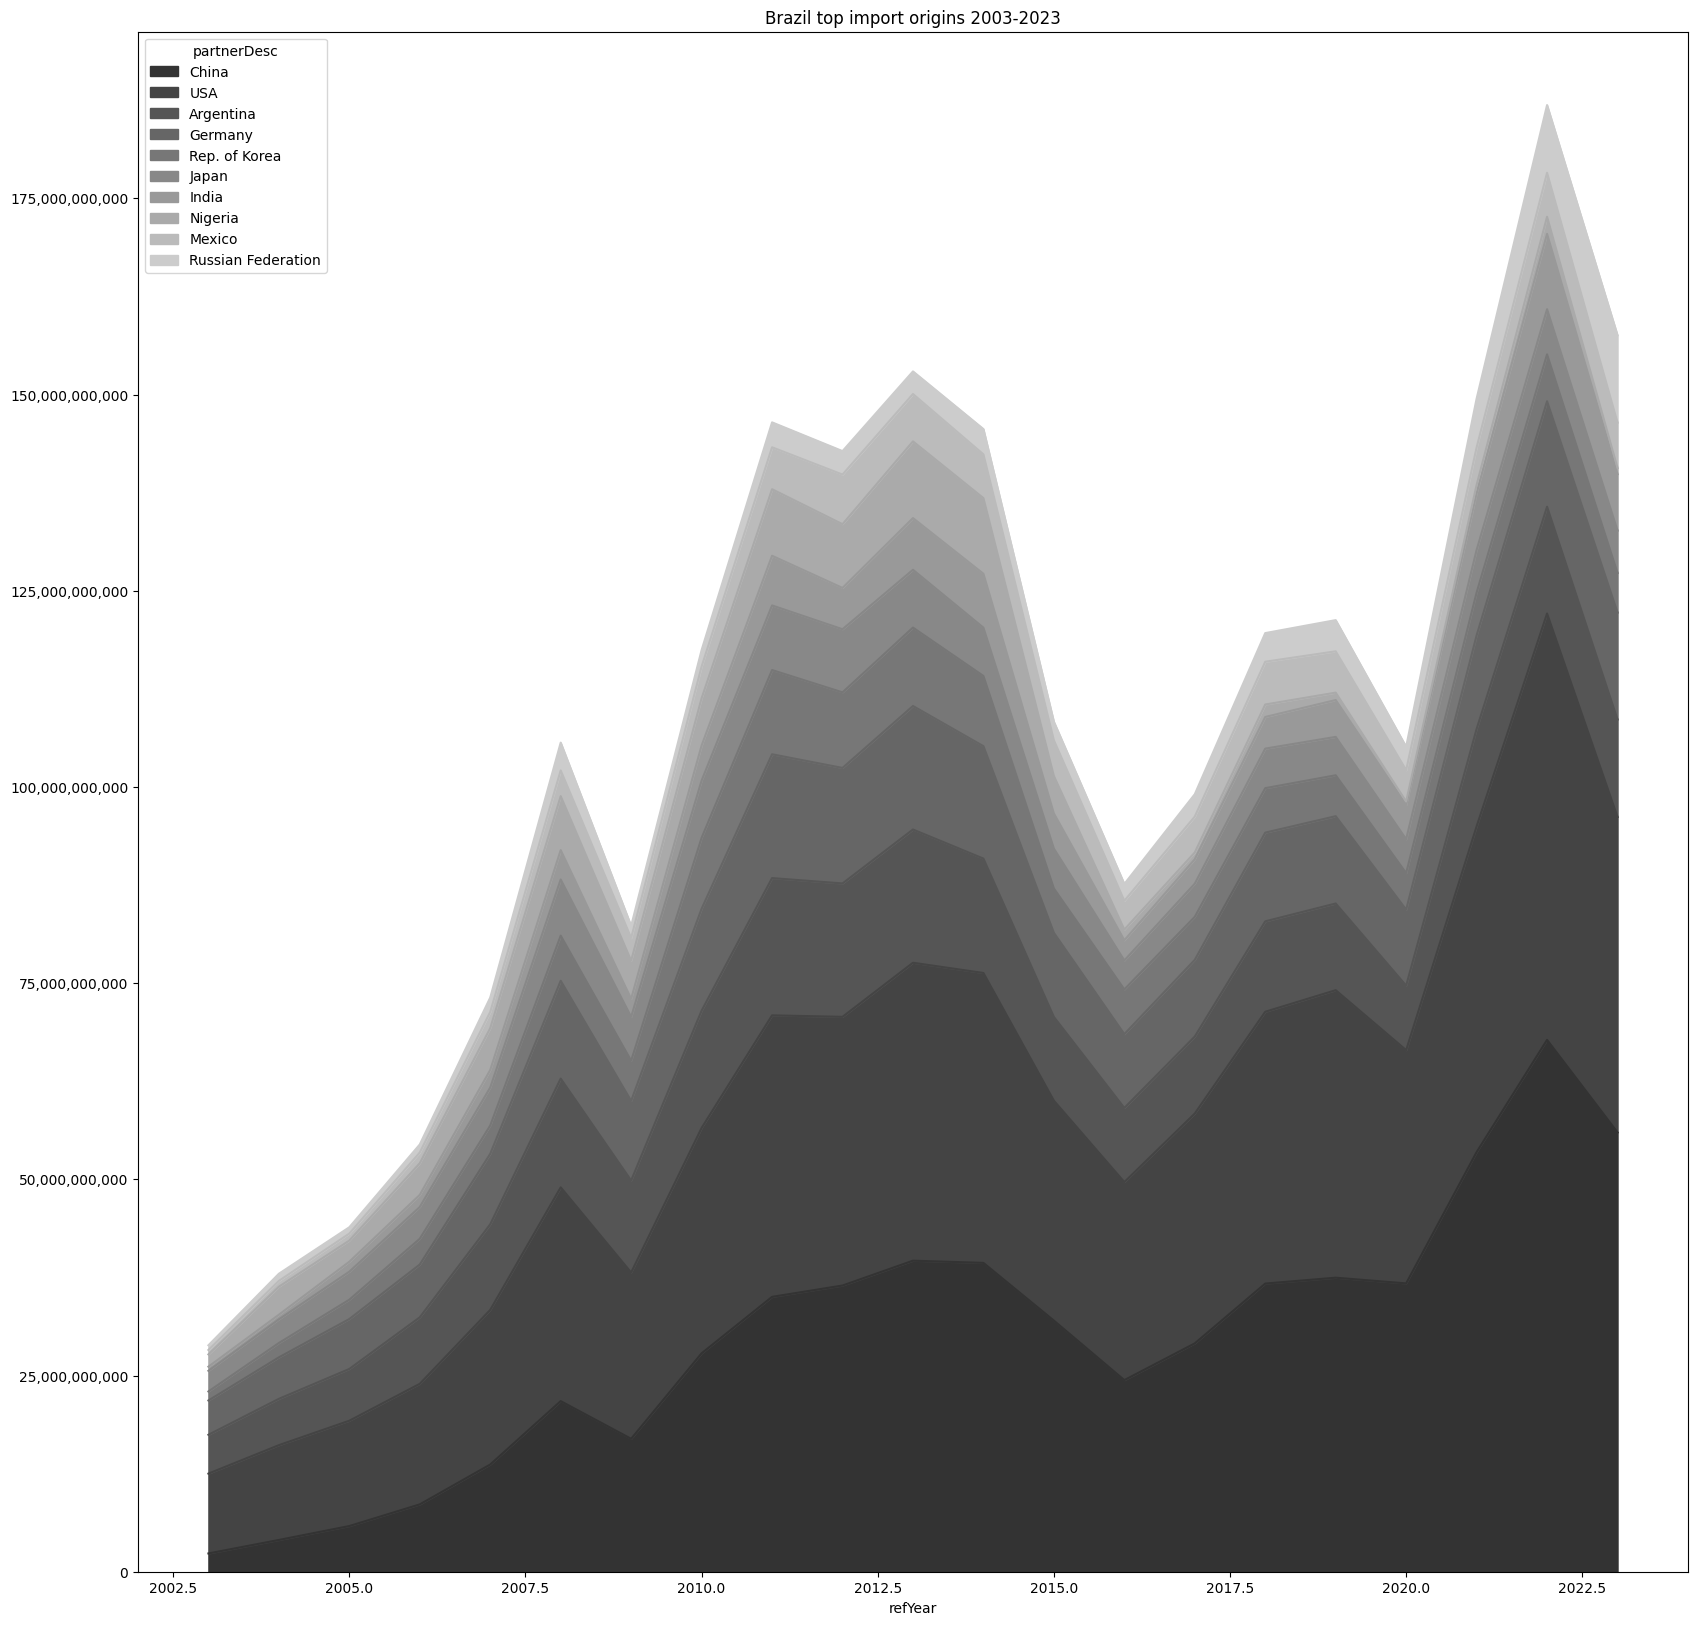

In [131]:
import matplotlib.pyplot as plt

title=f"{country_of_interest_name} top import origins {start_year}-{end_year}"
plotfile = f"reports/{country_of_interest_name}_3.1.4_import_partners_{start_year}-{end_year}.png"

# colors = ['red','lightsalmon','green','lightgreen','darkviolet','violet','blue','dodgerblue','orange','yellow','brown','black','grey','pink','cyan','magenta',]
# colors = ['crimson', 'darkorange', 'gold', 'limegreen', 'mediumseagreen', 'teal', 'deepskyblue', 'royalblue', 'indigo', 'mediumvioletred', 'hotpink', 'saddlebrown', 'grey', 'black', 'darkslategrey', 'darkkhaki']
colors = [ '#333333','#444444', '#555555', '#666666', '#777777', '#888888', '#999999', '#AAAAAA', '#BBBBBB', '#CCCCCC', '#DDDDDD', '#EEEEEE']
fig2 = values_only.plot.area(figsize=(20,20),title=title, color=colors)

for i, line in enumerate(fig2.get_lines()):
    n = i % len(colors)
    # print(i, line, colors[n])
    line.set_color(colors[n])

formatter = ticker.StrMethodFormatter('{x:,.0f}')
fig2.yaxis.set_major_formatter(formatter)

plt.savefig(plotfile)
plt.show()

In [132]:
plotfile

'reports/Brazil_3.1.4_import_partners_2003-2023.png'

In [133]:
show_only_columns = [(l1, country) for l1,country in pivoted.columns.tolist() if country in top_import_partners]
list(show_only_columns)

[('partner_perc', 'Argentina'),
 ('partner_perc', 'China'),
 ('partner_perc', 'Germany'),
 ('partner_perc', 'India'),
 ('partner_perc', 'Japan'),
 ('partner_perc', 'Mexico'),
 ('partner_perc', 'Nigeria'),
 ('partner_perc', 'Rep. of Korea'),
 ('partner_perc', 'Russian Federation'),
 ('partner_perc', 'USA'),
 ('primaryValue', 'Argentina'),
 ('primaryValue', 'China'),
 ('primaryValue', 'Germany'),
 ('primaryValue', 'India'),
 ('primaryValue', 'Japan'),
 ('primaryValue', 'Mexico'),
 ('primaryValue', 'Nigeria'),
 ('primaryValue', 'Rep. of Korea'),
 ('primaryValue', 'Russian Federation'),
 ('primaryValue', 'USA')]

#### Export to Excel

Table with the top import origins for the period of interest

In [135]:
top_partners_file = f'reports/{country_of_interest_name}_3.1.1_top_import_partners.xlsx'
top_partners_cols_file = f'reports/{country_of_interest_name}_3.1.2_top_import_partners_cols.xlsx'
import_top_partners_file = f'reports/{country_of_interest_name}_3.1.3_import_top_{show_only_top}_partners_{start_year}-{end_year}.xlsx'

imports[cols].sort_values(['refYear','flowCode','partner_rank']).to_excel(top_partners_file)
pivoted.to_excel(top_partners_cols_file)
pivoted[show_only_columns].reset_index().to_excel(import_top_partners_file)

print(f"Top import partners file: {top_partners_file}")
print(f"Top import partners cols file: {top_partners_cols_file}")
print(f"Import top partners file: {import_top_partners_file}")

Top import partners file: reports/Brazil_3.1.1_top_import_partners.xlsx
Top import partners cols file: reports/Brazil_3.1.2_top_import_partners_cols.xlsx
Import top partners file: reports/Brazil_3.1.3_import_top_5_partners_2003-2023.xlsx


### 3.2 Imports: products

#### Main imported products

In [136]:
import pandas as pd

# show 500 lines of dataframes
pd.set_option('display.max_rows', 500)

show_only_top=5
# years_of_interest = comtrade.year_range(2020, 2021)

print(country_of_interest_name, years_of_interest)


Brazil 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023


Get the products imported by country of interest

In [137]:
# If symmetric_reporting is "True" we get the exports from
#    the reported imports of all the countries
# i.e. instead of asking Country of Interest for export data we ask the world
#    for import data from Country of Interest

symmetric_reporting = False  # set to false to use reported exports by Country of Interest

if symmetric_reporting:
    reporterCode = None
    partnerCode = country_of_interest
    flowCode = 'X'
    reporter_column = 'partner'
    partner_column = 'reporter'
else:
    reporterCode = country_of_interest
    partnerCode = None
    flowCode = 'M'
    reporter_column = 'reporter'
    partner_column = 'partner'

In [138]:
import comtradetools

clCode = 'HS'
cmdDetail = 'AG6'  # AG2 aggregate two digits, top level, AG4 detail 4 digits, ... World bank uses AG6
df = comtradetools.getFinalData(
                        APIKEY,
                        reporterCode=reporterCode,
                        typeCode='C',  # commodities
                        freqCode='A',  # annual
                        flowCode=flowCode,
                        period=years_of_interest,
                        period_size=1,
                        partnerCode=partnerCode,
                        remove_world=False,
                        partner2Code=0,
                        clCode=clCode,
                        cmdCode=cmdDetail,
                        motCode=0,  # all means of transport
                        customsCode='C00',
                        includeDesc=True,
                        retry_if_empty=False,
                        cache=True
                        )
df.info()

INFO:root:Calling getFinalData for period 2003
DEBUG:root:Call ('b5cdc1c0678544b0ab5085f7292e6643',){'reporterCode': 76, 'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'M', 'period': '2003', 'partnerCode': None, 'partner2Code': 0, 'clCode': 'HS', 'cmdCode': 'AG6', 'motCode': 0, 'customsCode': 'C00', 'includeDesc': True}False
INFO:root:Using cached results for period 2003
INFO:root:Calling getFinalData for period 2004
DEBUG:root:Call ('b5cdc1c0678544b0ab5085f7292e6643',){'reporterCode': 76, 'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'M', 'period': '2004', 'partnerCode': None, 'partner2Code': 0, 'clCode': 'HS', 'cmdCode': 'AG6', 'motCode': 0, 'customsCode': 'C00', 'includeDesc': True}False
INFO:root:Using cached results for period 2004
INFO:root:Calling getFinalData for period 2005
DEBUG:root:Call ('b5cdc1c0678544b0ab5085f7292e6643',){'reporterCode': 76, 'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'M', 'period': '2005', 'partnerCode': None, 'partner2Code': 0, 'clCode': 'HS', 'cmdCode

In [139]:
print("Years available in the data:", list(df.refYear.unique()))

Years available in the data: [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


In [140]:
df.head()

,typeCode,freqCode,refPeriodId,refYear,refMonth,period,reporterCode,reporterISO,reporterDesc,flowCode,...,netWgt,isNetWgtEstimated,grossWgt,isGrossWgtEstimated,cifvalue,fobvalue,primaryValue,legacyEstimationFlag,isReported,isAggregate
0,C,A,20030101,2003,52,2003,76,BRA,Brazil,M,...,329.00,False,0.00,False,"39,628.00","38,421.00","39,628.00",0,False,True
1,C,A,20030101,2003,52,2003,76,BRA,Brazil,M,...,"1,093.00",False,0.00,False,"6,633.00","5,352.00","6,633.00",0,False,True
2,C,A,20030101,2003,52,2003,76,BRA,Brazil,M,...,"21,794.00",False,0.00,False,"198,413.00","189,883.00","198,413.00",0,False,True
3,C,A,20030101,2003,52,2003,76,BRA,Brazil,M,...,"1,623.00",False,0.00,False,"11,012.00","10,618.00","11,012.00",0,False,True
4,C,A,20030101,2003,52,2003,76,BRA,Brazil,M,...,"44,073.68",True,0.00,False,"1,022,365.00","995,750.00","1,022,365.00",6,False,True


Agreggate by product, keep the top products imported each year

In [141]:
import pandas as pd
import comtradetools
# show 500 lines
pd.options.display.max_rows=500
pd.options.display.float_format='{:,.2f}'.format

show_only_top = 5
imports = comtradetools.total_rank_perc(df,['refYear','flowCode','cmdCode'],'primaryValue','product',drop_duplicates=True)
imports = imports[imports['product_rank']<=show_only_top]
imports.info()

cols=['refYear','flowCode','product_rank','cmdCode', 'cmdDesc','product_sum','product_upper_perc','classificationCode','aggrLevel','isLeaf', 'product_upper_sum']
formats =  comtradetools.make_format(cols)

top_import_products_codes = imports['cmdCode'].unique()

print(f"Top products imported by {country_of_interest_name} in {years_of_interest}:\n {top_import_products_codes}")
for cmdCode in top_import_products_codes:
    print(f"   {cmdCode}: {comtradetools.HS_CODES.get(cmdCode,cmdCode)}")
imports[cols].sort_values(['refYear','flowCode','product_rank']).head(10).style.format(formats)


<class 'pandas.core.frame.DataFrame'>
Index: 105 entries, 123 to 1564672
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   typeCode                  105 non-null    object 
 1   freqCode                  105 non-null    object 
 2   refPeriodId               105 non-null    int64  
 3   refYear                   105 non-null    int64  
 4   refMonth                  105 non-null    int64  
 5   period                    105 non-null    object 
 6   reporterCode              105 non-null    int64  
 7   reporterISO               105 non-null    object 
 8   reporterDesc              105 non-null    object 
 9   flowCode                  105 non-null    object 
 10  flowDesc                  105 non-null    object 
 11  partnerCode               105 non-null    int64  
 12  partnerISO                105 non-null    object 
 13  partnerDesc               105 non-null    object 
 14  partner2C

,refYear,flowCode,product_rank,cmdCode,cmdDesc,product_sum,product_upper_perc,classificationCode,aggrLevel,isLeaf,product_upper_sum
5454,2003,M,1,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude","$7,815,023,562",7.534%,H2,6,True,"$103,733,366,198"
7656,2003,M,2,100190,Cereals; meslin and wheat other than durum,"$2,221,970,706",2.142%,H2,6,True,"$103,733,366,198"
123,2003,M,3,271019,"Oils; petroleum oils and oils obtained from bituminous minerals, not crude; preparations n.e.c., containing by weight 70% or more of petroleum oils or oils obtained from bituminous minerals, (excluding waste oils), other than light oils and preparations","$2,137,334,928",2.060%,H2,6,True,"$103,733,366,198"
25686,2003,M,4,271600,Electrical energy,"$2,074,633,882",2.000%,H2,6,True,"$103,733,366,198"
1084,2003,M,5,854221,"Electronic integrated circuits and microassemblies; monolithic integrated circuits, digital","$1,990,005,220",1.918%,H2,6,True,"$103,733,366,198"
65396,2004,M,1,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude","$13,889,860,172",10.295%,H2,6,True,"$134,918,160,648"
116256,2004,M,2,854221,"Electronic integrated circuits and microassemblies; monolithic integrated circuits, digital","$2,660,466,270",1.972%,H2,6,True,"$134,918,160,648"
113719,2004,M,3,852990,"Reception and transmission apparatus; for use with the apparatus of heading no. 8525 to 8528, excluding aerials and aerial reflectors","$2,318,407,164",1.718%,H2,6,True,"$134,918,160,648"
72181,2004,M,4,310420,"Fertilizers, mineral or chemical; potassic, potassium chloride","$2,272,020,338",1.684%,H2,6,True,"$134,918,160,648"
65441,2004,M,5,271019,"Oils; petroleum oils and oils obtained from bituminous minerals, not crude; preparations n.e.c., containing by weight 70% or more of petroleum oils or oils obtained from bituminous minerals, (excluding waste oils), other than light oils and preparations","$2,213,451,520",1.641%,H2,6,True,"$134,918,160,648"


### Caveat

For Angola results match https://trendeconomy.com/data/h2/Angola/TOTAL for AG2 and AG4 but not https://www.statista.com/statistics/1143152/value-of-imports-into-angola-by-category/  and close but not same as https://globaledge.msu.edu/countries/angola/tradestats

The imports match World Bank Wits data mostly, but in some years 
there seems to be a mismatch of HS Codes, with different descriptions in Wits
and values that sometimes match AG4 and not AG6 (2015,total is AG4:2710 not AG6:271012 )
and in same cases match the first 5 digits (2015: 73042 "Casings tubing...", 2021 10011, Durum Wheat)

Use the following cell to compute totals for codes with first 5 digit in common to compare with other sources

In [340]:
import pandas as pd

pd.set_option('display.max_colwidth', 200)
pd.options.display.float_format = '{:,.2f}'.format

code_prefix = '10011'
cols=['refYear','flowCode','cmdCode','cmdDesc', 'classificationCode','aggrLevel','primaryValue','product_rank','product_perc']

# select rows and columns
selected_rows = df[(df['refYear']==2021) & (df['cmdCode'].str.startswith(code_prefix))][cols].sort_values(by=['primaryValue'],ascending=False).head(50)

# add total of primaryValue column
total = selected_rows['primaryValue'].sum()
selected_rows.loc['Total'] = pd.Series({'primaryValue': total})

# display selected rows
selected_rows


,refYear,flowCode,cmdCode,cmdDesc,classificationCode,aggrLevel,primaryValue,product_rank,product_perc
775232,"2,021.00",M,100119,"Cereals; wheat and meslin, durum wheat, other than seed",H5,6.00,"227,412,579.20",2.00,0.01
775234,"2,021.00",M,100119,"Cereals; wheat and meslin, durum wheat, other than seed",H5,6.00,"111,891,038.52",2.00,0.00
775239,"2,021.00",M,100119,"Cereals; wheat and meslin, durum wheat, other than seed",H5,6.00,"57,244,189.03",2.00,0.00
775233,"2,021.00",M,100119,"Cereals; wheat and meslin, durum wheat, other than seed",H5,6.00,"28,665,369.69",2.00,0.00
775235,"2,021.00",M,100119,"Cereals; wheat and meslin, durum wheat, other than seed",H5,6.00,"12,131,357.73",2.00,0.00
775241,"2,021.00",M,100119,"Cereals; wheat and meslin, durum wheat, other than seed",H5,6.00,"7,707,737.18",2.00,0.00
775236,"2,021.00",M,100119,"Cereals; wheat and meslin, durum wheat, other than seed",H5,6.00,"4,055,544.08",2.00,0.00
775237,"2,021.00",M,100119,"Cereals; wheat and meslin, durum wheat, other than seed",H5,6.00,"3,836,516.45",2.00,0.00
775226,"2,021.00",M,100111,"Cereals; wheat and meslin, durum wheat, seed",H5,6.00,"2,305,159.68",632.00,0.00
775229,"2,021.00",M,100111,"Cereals; wheat and meslin, durum wheat, seed",H5,6.00,"1,984,050.50",632.00,0.00


In [142]:
print("Years available in the data:", list(imports.refYear.unique()))

Years available in the data: [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


#### Export to Excel

In [143]:
filename = f'reports/{country_of_interest_name}_3.2_imports_products_{clCode}-{cmdDetail}-{imports["refYear"].min()}-{imports["refYear"].max()}.xlsx'
print("Exporting to ",filename)
imports[cols].sort_values(['refYear','flowCode','product_rank']).to_excel(filename,index=False)

Exporting to  reports/Brazil_3.2_imports_products_HS-AG6-2003-2023.xlsx


### 3.3 Import partners / product analysis

Which are the partners selling the top imports by country of interest

In [144]:
# If symmetric_reporting is "True" we get the exports from
#    the reported imports of all the countries
# i.e. instead of asking Country of Interest for export data we ask the world
#    for import data from Country of Interest

symmetric_reporting = False  # set to false to use reported exports by Country of Interest

if symmetric_reporting:
    reporterCode = None
    partnerCode = country_of_interest
    flowCode = 'X'
    reporter_column = 'partner'
    partner_column = 'reporter'
else:
    reporterCode = country_of_interest
    partnerCode = None
    flowCode = 'M'
    reporter_column = 'reporter'
    partner_column = 'partner'

In [145]:
import warnings
warnings.filterwarnings('default')

clCode = 'HS'
cmdDetail = 'AG6'  # not all countries report at higher detail

df = comtradetools.getFinalData(
                        APIKEY,
                        reporterCode=reporterCode,
                        typeCode='C',  # commodities
                        freqCode='A',  # annual
                        flowCode=flowCode,
                        period=years_of_interest,
                        period_size=1, # lots of data, better segment
                        partnerCode=partnerCode,
                        remove_world=False,
                        partner2Code=0,
                        clCode=clCode,
                        cmdCode=cmdDetail,
                        motCode=0,  # all means of transport
                        customsCode='C00',
                        includeDesc=True,
                        retry_if_empty=False,
                        cache=True
                        )
df.info()

INFO:root:Calling getFinalData for period 2003
DEBUG:root:Call ('b5cdc1c0678544b0ab5085f7292e6643',){'reporterCode': 76, 'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'M', 'period': '2003', 'partnerCode': None, 'partner2Code': 0, 'clCode': 'HS', 'cmdCode': 'AG6', 'motCode': 0, 'customsCode': 'C00', 'includeDesc': True}False
INFO:root:Using cached results for period 2003
INFO:root:Calling getFinalData for period 2004
DEBUG:root:Call ('b5cdc1c0678544b0ab5085f7292e6643',){'reporterCode': 76, 'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'M', 'period': '2004', 'partnerCode': None, 'partner2Code': 0, 'clCode': 'HS', 'cmdCode': 'AG6', 'motCode': 0, 'customsCode': 'C00', 'includeDesc': True}False
INFO:root:Using cached results for period 2004
INFO:root:Calling getFinalData for period 2005
DEBUG:root:Call ('b5cdc1c0678544b0ab5085f7292e6643',){'reporterCode': 76, 'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'M', 'period': '2005', 'partnerCode': None, 'partner2Code': 0, 'clCode': 'HS', 'cmdCode

In [146]:
cols2=['refYear','flowCode','reporterDesc','partnerDesc','primaryValue','cmdCode','cmdDesc']
df[cols2].sample(10)

,refYear,flowCode,reporterDesc,partnerDesc,primaryValue,cmdCode,cmdDesc
1326816,2020,M,Brazil,Sweden,"7,851,368.00",870894,"Vehicle parts; steering wheels, steering colum..."
1038535,2017,M,Brazil,Poland,"179,908.00",382100,Prepared culture media for the development or ...
1208149,2019,M,Brazil,Netherlands,"112,585.00",580127,"Fabrics; woven pile, of cotton, warp pile fabr..."
234431,2006,M,Brazil,Poland,"8,983.00",841370,"Pumps; centrifugal, n.e.s. in heading no. 8413..."
785704,2013,M,Brazil,Sweden,"4,025.00",961700,"Vacuum flasks and other vacuum vessels, comple..."
138494,2005,M,Brazil,France,"106,321.00",380993,Finishing agents and dye carriers; to accelera...
1270137,2020,M,Brazil,"Other Asia, nes","92,185.00",300290,"Toxins, cultures of micro-organisms (excluding..."
921066,2015,M,Brazil,Sweden,"213,240.00",842691,Cranes and derricks; designed for mounting on ...
1104728,2018,M,Brazil,Slovenia,59.00,250700,Kaolin and other kaolinic clays; whether or no...
429968,2009,M,Brazil,Mauritius,"40,824.00",620520,"Shirts; men's or boys', of cotton (not knitted..."


In [147]:
df.refYear.unique()

array([2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])

Aggregate by partner and keep the main ones

In [148]:
import pandas as pd
import comtradetools
import warnings

# show 500 lines
pd.options.display.max_rows=500
pd.options.display.float_format='{:,.2f}'.format

show_only_top = 5   # change to have more top partners

print(f"Top products imported by {country_of_interest_name} in {years_of_interest}:\n {top_import_products_codes}")
for cmdCode in top_import_products_codes:
    print(f"   {cmdCode}: {comtradetools.HS_CODES.get(cmdCode,cmdCode)}")

print(f"Top import partners ({len(top_import_partners)}): {top_import_partners}")
prefix='cmd_partner'
# remove world
if 0 in df[f'{partner_column}Code'].unique():
    warnings.warn("Removing world from data")
    df = df[df[f'{partner_column}Code']!=0]

products_and_partners = comtradetools.total_rank_perc(df,['refYear','flowCode','cmdCode',f'{partner_column}Code'],'primaryValue',prefix,drop_duplicates=True)
cols=['refYear','flowCode','cmdDesc','cmdCode',f'{partner_column}Desc',f'{prefix}_rank',f'{prefix}_sum',f'{prefix}_perc',f'{prefix}_upper_sum']
formats=comtradetools.make_format(cols)

products_and_partners=products_and_partners[(products_and_partners['cmdCode'].isin(top_import_products_codes)
                        & (products_and_partners[f'{prefix}_rank']<=show_only_top))]
print(f"Data available for years {products_and_partners.refYear.unique()}")


Top products imported by Brazil in 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023:
 ['271019' '854221' '270900' '100190' '271600' '310420' '852990' '271011'
 '851770' '870323' '271121' '300490' '271012' '270112' '841191' '300220'
 '854143']
   271019: Petroleum oils and oils from bituminous minerals, not containing biodiesel, not crude, not waste oils; preparations n.e.c, containing by weight 70% or more of petroleum oils or oils from bituminous minerals; not light oils and preparations
   854221: 854221
   270900: Oils; petroleum oils and oils obtained from bituminous minerals, crude
   100190: 100190
   271600: Electrical energy
   310420: Fertilizers, mineral or chemical; potassic, potassium chloride
   852990: Reception and transmission apparatus; for use with the apparatus of heading no. 8524 to 8528, excluding aerials and aerial reflectors
   271011: 271011
   851770: 851770
   870323: Vehicles; with only spark-ignition in

/var/folders/x7/qzytnd752559g0w475rfwkx00000gn/T/ipykernel_74715/890561552.py:19: UserWarning: Removing world from data
  warnings.warn("Removing world from data")


Data available for years [2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016
 2017 2018 2019 2020 2021 2022 2023]


### Partners for main import products

In [149]:
products_and_partners[cols].sort_values(['refYear','flowCode',f'{prefix}_upper_sum',f'{prefix}_rank'],
                                        ascending=[True,True,False,True])\
                                            .head(30).style.format(formats) #.hide(axis='index')

,refYear,flowCode,cmdDesc,cmdCode,partnerDesc,cmd_partner_rank,cmd_partner_sum,cmd_partner_perc,cmd_partner_upper_sum
55530,2003,M,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",270900,Nigeria,1,"$1,487,962,652",38.080%,"$3,907,511,781"
8722,2003,M,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",270900,Algeria,2,"$839,925,447",21.495%,"$3,907,511,781"
7800,2003,M,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",270900,Saudi Arabia,3,"$747,812,887",19.138%,"$3,907,511,781"
30675,2003,M,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",270900,Iraq,4,"$287,114,345",7.348%,"$3,907,511,781"
35125,2003,M,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",270900,Argentina,5,"$164,370,018",4.207%,"$3,907,511,781"
36068,2003,M,Cereals; meslin and wheat other than durum,100190,Argentina,1,"$948,745,687",85.397%,"$1,110,985,353"
32409,2003,M,Cereals; meslin and wheat other than durum,100190,USA,2,"$81,194,987",7.308%,"$1,110,985,353"
38952,2003,M,Cereals; meslin and wheat other than durum,100190,Poland,3,"$42,296,062",3.807%,"$1,110,985,353"
58606,2003,M,Cereals; meslin and wheat other than durum,100190,Canada,4,"$27,176,125",2.446%,"$1,110,985,353"
56154,2003,M,Cereals; meslin and wheat other than durum,100190,Paraguay,5,"$9,355,211",0.842%,"$1,110,985,353"


In [150]:
filename = f'reports/{country_of_interest_name}_3.3_imports_products_partners_{clCode}-{cmdDetail}-{products_and_partners["refYear"].min()}-{products_and_partners["refYear"].max()}.xlsx'
print("Exporting to ",filename)
products_and_partners[cols].sort_values(['refYear','flowCode',f'{prefix}_upper_sum',f'{prefix}_rank'],
                                        ascending=[True,True,False,True]).to_excel(filename, index=False)

Exporting to  reports/Brazil_3.3_imports_products_partners_HS-AG6-2003-2023.xlsx


### 3.4 Main partners and main products imported by country of interest

Detail of the main products by import partner.

Allows to analyse the mix of products of the main suppliers from this country.



In [151]:
top_import_partners

array(['Argentina', 'China', 'Japan', 'USA', 'Germany', 'Nigeria',
       'Rep. of Korea', 'Mexico', 'India', 'Russian Federation'],
      dtype=object)

In [152]:
import comtradetools

show_only_top = 5  # for suppliers with wide range of products e.g PT->AO increase

print(f"Top import partners ({len(top_import_partners)}): {top_import_partners}")
prefix='partner_cmd'
suppliers_and_products = comtradetools.total_rank_perc(df,['refYear','flowCode',f'{partner_column}Code','cmdCode'],'primaryValue',prefix,drop_duplicates=False)

cols=['refYear','flowCode',f'{partner_column}Desc',f'{prefix}_rank','cmdCode','cmdDesc',f'{prefix}_sum',f'{prefix}_perc',f'{prefix}_upper_sum']
formats = comtradetools.make_format(cols)
suppliers_and_products=suppliers_and_products[(suppliers_and_products[f'{partner_column}Desc'].isin(top_import_partners)
                       & (suppliers_and_products[f'{prefix}_rank']<=show_only_top))]

print("First rows")
suppliers_and_products[suppliers_and_products[f'{prefix}_rank']<=show_only_top][cols].sort_values(
    ['refYear','flowCode','partner_cmd_upper_sum',f'{prefix}_sum',f'{prefix}_rank'],
    ascending=[True,True,False,False,False]).head(10).style.format(formats).hide(axis='index')

Top import partners (10): ['Argentina' 'China' 'Japan' 'USA' 'Germany' 'Nigeria' 'Rep. of Korea'
 'Mexico' 'India' 'Russian Federation']
First rows


refYear,flowCode,partnerDesc,partner_cmd_rank,cmdCode,cmdDesc,partner_cmd_sum,partner_cmd_perc,partner_cmd_upper_sum
2003,M,USA,1,850239,"Electric generating sets; (excluding those with spark-ignition or compression-ignition internal combustion piston engines), other than wind powered","$501,288,057",4.927%,"$10,175,264,493"
2003,M,USA,2,841112,Turbo-jets; of a thrust exceeding 25kN,"$398,407,191",3.915%,"$10,175,264,493"
2003,M,USA,3,847330,"Machines; parts and accessories of automatic data processing, magnetic or optical readers, digital processing units","$222,388,143",2.186%,"$10,175,264,493"
2003,M,USA,4,300490,"Medicaments; consisting of mixed or unmixed products n.e.s. in heading no. 3004, for therapeutic or prophylactic uses, packaged for retail sale","$212,410,719",2.088%,"$10,175,264,493"
2003,M,USA,5,854221,"Electronic integrated circuits and microassemblies; monolithic integrated circuits, digital","$190,003,192",1.867%,"$10,175,264,493"
2003,M,Argentina,1,100190,Cereals; meslin and wheat other than durum,"$948,745,687",19.170%,"$4,949,242,272"
2003,M,Argentina,2,271011,"Petroleum oils and oils from bituminous minerals, not crude or waste oils; preparations n.e.c. with 70% or more (weight),of petroleum oils or oils from bituminous minerals; being the basic constituents of the preparations: light oils and preparations","$387,312,844",7.826%,"$4,949,242,272"
2003,M,Argentina,3,870421,"Vehicles; compression-ignition internal combustion piston engine (diesel or semi-diesel), for transport of goods, (of a gvw not exceeding 5 tonnes), nes in item no 8704.1","$169,740,807",3.430%,"$4,949,242,272"
2003,M,Argentina,4,870323,"Vehicles; spark-ignition internal combustion reciprocating piston engine, cylinder capacity exceeding 1500cc but not exceeding 3000cc","$165,662,907",3.347%,"$4,949,242,272"
2003,M,Argentina,5,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude","$164,370,018",3.321%,"$4,949,242,272"


Last rows

In [153]:

suppliers_and_products[suppliers_and_products[f'{prefix}_rank']<=show_only_top][cols].sort_values(
    ['refYear','flowCode','partner_cmd_upper_sum',f'{prefix}_sum',f'{prefix}_rank'],
    ascending=[True,True,False,False,False]).tail(10).style.format(formats).hide(axis='index')

refYear,flowCode,partnerDesc,partner_cmd_rank,cmdCode,cmdDesc,partner_cmd_sum,partner_cmd_perc,partner_cmd_upper_sum
2023,M,Rep. of Korea,1,854231,"Electronic integrated circuits; processors and controllers, whether or not combined with memories, converters, logic circuits, amplifiers, clock and timing circuits, or other circuits","$446,782,581",8.846%,"$5,050,818,381"
2023,M,Rep. of Korea,2,854232,Electronic integrated circuits; memories,"$411,016,541",8.138%,"$5,050,818,381"
2023,M,Rep. of Korea,3,870840,Vehicle parts; gear boxes and parts thereof,"$321,482,124",6.365%,"$5,050,818,381"
2023,M,Rep. of Korea,4,854239,Electronic integrated circuits; n.e.c. in heading no. 8542,"$181,826,073",3.600%,"$5,050,818,381"
2023,M,Rep. of Korea,5,840733,"Engines; reciprocating piston engines, of a kind used for the propulsion of vehicles of chapter 87, of a cylinder capacity exceeding 250cc but not exceeding 1000cc","$174,212,683",3.449%,"$5,050,818,381"
2023,M,Nigeria,1,310210,"Fertilizers, mineral or chemical; nitrogenous, urea, whether or not in aqueous solution","$474,564,849",60.031%,"$790,530,952"
2023,M,Nigeria,2,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude","$304,427,078",38.509%,"$790,530,952"
2023,M,Nigeria,3,760200,Aluminium; waste and scrap,"$4,289,727",0.543%,"$790,530,952"
2023,M,Nigeria,4,550320,"Fibres; synthetic staple fibres, of polyesters, not carded, combed or otherwise processed for spinning","$2,238,830",0.283%,"$790,530,952"
2023,M,Nigeria,5,700529,"Glass; float glass and surface ground or polished glass, in sheets, non-wired, (other than coloured throughout the mass (body tinted), opacified, flashed or merely surface ground)","$1,888,734",0.239%,"$790,530,952"


#### Export to Excel

In [154]:
filename = f'reports/{country_of_interest_name}_3.4_imports_partners_products_{clCode}-{cmdDetail}-{products_and_partners["refYear"].min()}-{products_and_partners["refYear"].max()}.xlsx'

suppliers_and_products[suppliers_and_products[f'{prefix}_rank']<=show_only_top][cols].sort_values(
    ['refYear','flowCode','partner_cmd_upper_sum',f'{prefix}_sum',f'{prefix}_rank'],
    ascending=[True,True,False,False,False]).to_excel(filename, index=False)

print("Exporting to ",filename)

Exporting to  reports/Brazil_3.4_imports_partners_products_HS-AG6-2003-2023.xlsx


### 3.5 Get the alternative clients for country of interest suppliers

For each year, supplier, imported commodity, fetch all the 
exports of the commodity by the supplier to other countries, and
compute the ranking of country of interest among the clients
of partner for that commodity.

Country of interest: Angola, in 2022 Argentina was #1 supplier of Angola for commodity
code 100119 "Cereals; wheat and meslin, durum wheat, other than seed"; fetch all the clients of Argentina for 100119 and compute the ranking of Angola.

First step is to get the combos os partner and commodity.



In [155]:
top_import_products_codes

array(['271019', '854221', '270900', '100190', '271600', '310420',
       '852990', '271011', '851770', '870323', '271121', '300490',
       '271012', '270112', '841191', '300220', '854143'], dtype=object)

In [156]:
combos_of_interest = suppliers_and_products[(suppliers_and_products['cmdCode'].isin(top_import_products_codes)
                & (suppliers_and_products[f'{partner_column}Code'].isin(top_import_partners_codes)))][[f'{partner_column}Code','cmdCode']].drop_duplicates()
combos_of_interest = [tuple(x) for x in combos_of_interest.values]
len(combos_of_interest)

51

In [157]:
# create lists of commodities codes and country codes to query comtrade
cmdCode_list = [cmdCode for (countryCode,cmdCode) in combos_of_interest]
cmdCode_list = list(set(cmdCode_list))
countryCode_list = [countryCode for (countryCode,cmdCode) in combos_of_interest]
countryCode_list = list(set(countryCode_list))
cmdCodeCSV = ','.join(cmdCode_list)
countryCodeCSV = ','.join(map(str,countryCode_list))

Get the all clients of suppliers for the products imported by country of interest

In [158]:
print("Years of interest: ", years_of_interest)
print("countryCodeCSV: ", countryCodeCSV)
print("cmdCodeCSV: ", cmdCodeCSV)

df = comtradetools.getFinalData(APIKEY,
                                typeCode='C',  # commodities
                                freqCode='A',  # annual
                                flowCode='X',
                                reporterCode=countryCodeCSV,
                                partnerCode=None,
                                remove_world=True,
                                partner2Code=0,
                                period=years_of_interest,
                                period_size=1,
                                clCode=clCode,
                                cmdCode=cmdCodeCSV,  # Top level product types
                                motCode=0,  # all means of transport
                                customsCode='C00',
                                includeDesc=True,
                                retry_if_empty=False,
                                cache=True,

                                )

Years of interest:  2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
countryCodeCSV:  32,643,484,392,842,276,566,410,699,156
cmdCodeCSV:  852990,271600,300490,870323,310420,100190,271011,854221,851770,270112,271012,271121,300220,271019,854143,841191,270900
INFO:root:Calling getFinalData for period 2003
DEBUG:root:Call ('b5cdc1c0678544b0ab5085f7292e6643',){'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'X', 'reporterCode': '32,643,484,392,842,276,566,410,699,156', 'partnerCode': None, 'partner2Code': 0, 'period': '2003', 'clCode': 'HS', 'cmdCode': '852990,271600,300490,870323,310420,100190,271011,854221,851770,270112,271012,271121,300220,271019,854143,841191,270900', 'motCode': 0, 'customsCode': 'C00', 'includeDesc': True}False
DEBUG:root:Calling comtradeapicall.getFinalData with ('b5cdc1c0678544b0ab5085f7292e6643',) {'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'X', 'reporterCode': '32,643,484,392,842,276,566,410,699,156', 'partne

/Users/jrc/develop/cipf-comtrade/venv/lib/python3.10/site-packages/comtradeapicall/PreviewGet.py:137: ResourceWarning: unclosed <ssl.SSLSocket fd=87, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('172.23.7.61', 52851), raddr=('20.101.83.117', 443)>
  return getPreviewData(subscription_key, 'FINAL', typeCode, freqCode, clCode, period, reporterCode,


DEBUG:urllib3.connectionpool:https://comtradeapi.un.org:443 "GET /data/v1/get/C/A/HS?reportercode=32%2C643%2C484%2C392%2C842%2C276%2C566%2C410%2C699%2C156&flowCode=X&period=2004&cmdCode=852990%2C271600%2C300490%2C870323%2C310420%2C100190%2C271011%2C854221%2C851770%2C270112%2C271012%2C271121%2C300220%2C271019%2C854143%2C841191%2C270900&partner2Code=0&motCode=0&customsCode=C00&includeDesc=True&subscription-key=b5cdc1c0678544b0ab5085f7292e6643 HTTP/1.1" 200 None
DEBUG:root:Number of records fetched: 310529
DEBUG:root:Number of record in temp: 310529
INFO:root:Calling getFinalData for period 2005
DEBUG:root:Call ('b5cdc1c0678544b0ab5085f7292e6643',){'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'X', 'reporterCode': '32,643,484,392,842,276,566,410,699,156', 'partnerCode': None, 'partner2Code': 0, 'period': '2005', 'clCode': 'HS', 'cmdCode': '852990,271600,300490,870323,310420,100190,271011,854221,851770,270112,271012,271121,300220,271019,854143,841191,270900', 'motCode': 0, 'customsCode': '

/Users/jrc/develop/cipf-comtrade/venv/lib/python3.10/site-packages/comtradeapicall/PreviewGet.py:137: ResourceWarning: unclosed <ssl.SSLSocket fd=87, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('172.23.7.61', 52930), raddr=('20.101.83.117', 443)>
  return getPreviewData(subscription_key, 'FINAL', typeCode, freqCode, clCode, period, reporterCode,


DEBUG:urllib3.connectionpool:https://comtradeapi.un.org:443 "GET /data/v1/get/C/A/HS?reportercode=32%2C643%2C484%2C392%2C842%2C276%2C566%2C410%2C699%2C156&flowCode=X&period=2005&cmdCode=852990%2C271600%2C300490%2C870323%2C310420%2C100190%2C271011%2C854221%2C851770%2C270112%2C271012%2C271121%2C300220%2C271019%2C854143%2C841191%2C270900&partner2Code=0&motCode=0&customsCode=C00&includeDesc=True&subscription-key=b5cdc1c0678544b0ab5085f7292e6643 HTTP/1.1" 200 None
DEBUG:root:Number of records fetched: 320775
DEBUG:root:Number of record in temp: 320775
INFO:root:Calling getFinalData for period 2006
DEBUG:root:Call ('b5cdc1c0678544b0ab5085f7292e6643',){'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'X', 'reporterCode': '32,643,484,392,842,276,566,410,699,156', 'partnerCode': None, 'partner2Code': 0, 'period': '2006', 'clCode': 'HS', 'cmdCode': '852990,271600,300490,870323,310420,100190,271011,854221,851770,270112,271012,271121,300220,271019,854143,841191,270900', 'motCode': 0, 'customsCode': '

/Users/jrc/develop/cipf-comtrade/venv/lib/python3.10/site-packages/comtradeapicall/PreviewGet.py:137: ResourceWarning: unclosed <ssl.SSLSocket fd=87, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('172.23.7.61', 52954), raddr=('20.101.83.117', 443)>
  return getPreviewData(subscription_key, 'FINAL', typeCode, freqCode, clCode, period, reporterCode,


DEBUG:urllib3.connectionpool:https://comtradeapi.un.org:443 "GET /data/v1/get/C/A/HS?reportercode=32%2C643%2C484%2C392%2C842%2C276%2C566%2C410%2C699%2C156&flowCode=X&period=2006&cmdCode=852990%2C271600%2C300490%2C870323%2C310420%2C100190%2C271011%2C854221%2C851770%2C270112%2C271012%2C271121%2C300220%2C271019%2C854143%2C841191%2C270900&partner2Code=0&motCode=0&customsCode=C00&includeDesc=True&subscription-key=b5cdc1c0678544b0ab5085f7292e6643 HTTP/1.1" 200 None
DEBUG:root:Number of records fetched: 332431
DEBUG:root:Number of record in temp: 332431
INFO:root:Calling getFinalData for period 2007
DEBUG:root:Call ('b5cdc1c0678544b0ab5085f7292e6643',){'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'X', 'reporterCode': '32,643,484,392,842,276,566,410,699,156', 'partnerCode': None, 'partner2Code': 0, 'period': '2007', 'clCode': 'HS', 'cmdCode': '852990,271600,300490,870323,310420,100190,271011,854221,851770,270112,271012,271121,300220,271019,854143,841191,270900', 'motCode': 0, 'customsCode': '

/Users/jrc/develop/cipf-comtrade/venv/lib/python3.10/site-packages/comtradeapicall/PreviewGet.py:137: ResourceWarning: unclosed <ssl.SSLSocket fd=87, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('172.23.7.61', 52977), raddr=('20.101.83.117', 443)>
  return getPreviewData(subscription_key, 'FINAL', typeCode, freqCode, clCode, period, reporterCode,


DEBUG:urllib3.connectionpool:https://comtradeapi.un.org:443 "GET /data/v1/get/C/A/HS?reportercode=32%2C643%2C484%2C392%2C842%2C276%2C566%2C410%2C699%2C156&flowCode=X&period=2007&cmdCode=852990%2C271600%2C300490%2C870323%2C310420%2C100190%2C271011%2C854221%2C851770%2C270112%2C271012%2C271121%2C300220%2C271019%2C854143%2C841191%2C270900&partner2Code=0&motCode=0&customsCode=C00&includeDesc=True&subscription-key=b5cdc1c0678544b0ab5085f7292e6643 HTTP/1.1" 200 None
DEBUG:root:Number of records fetched: 344040
DEBUG:root:Number of record in temp: 344040
INFO:root:Calling getFinalData for period 2008
DEBUG:root:Call ('b5cdc1c0678544b0ab5085f7292e6643',){'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'X', 'reporterCode': '32,643,484,392,842,276,566,410,699,156', 'partnerCode': None, 'partner2Code': 0, 'period': '2008', 'clCode': 'HS', 'cmdCode': '852990,271600,300490,870323,310420,100190,271011,854221,851770,270112,271012,271121,300220,271019,854143,841191,270900', 'motCode': 0, 'customsCode': '

/Users/jrc/develop/cipf-comtrade/venv/lib/python3.10/site-packages/comtradeapicall/PreviewGet.py:137: ResourceWarning: unclosed <ssl.SSLSocket fd=87, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('172.23.7.61', 52991), raddr=('20.101.83.117', 443)>
  return getPreviewData(subscription_key, 'FINAL', typeCode, freqCode, clCode, period, reporterCode,


DEBUG:urllib3.connectionpool:https://comtradeapi.un.org:443 "GET /data/v1/get/C/A/HS?reportercode=32%2C643%2C484%2C392%2C842%2C276%2C566%2C410%2C699%2C156&flowCode=X&period=2008&cmdCode=852990%2C271600%2C300490%2C870323%2C310420%2C100190%2C271011%2C854221%2C851770%2C270112%2C271012%2C271121%2C300220%2C271019%2C854143%2C841191%2C270900&partner2Code=0&motCode=0&customsCode=C00&includeDesc=True&subscription-key=b5cdc1c0678544b0ab5085f7292e6643 HTTP/1.1" 200 None
DEBUG:root:Number of records fetched: 363310
DEBUG:root:Number of record in temp: 363310
INFO:root:Calling getFinalData for period 2009
DEBUG:root:Call ('b5cdc1c0678544b0ab5085f7292e6643',){'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'X', 'reporterCode': '32,643,484,392,842,276,566,410,699,156', 'partnerCode': None, 'partner2Code': 0, 'period': '2009', 'clCode': 'HS', 'cmdCode': '852990,271600,300490,870323,310420,100190,271011,854221,851770,270112,271012,271121,300220,271019,854143,841191,270900', 'motCode': 0, 'customsCode': '

/Users/jrc/develop/cipf-comtrade/venv/lib/python3.10/site-packages/comtradeapicall/PreviewGet.py:137: ResourceWarning: unclosed <ssl.SSLSocket fd=87, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('172.23.7.61', 53015), raddr=('20.101.83.117', 443)>
  return getPreviewData(subscription_key, 'FINAL', typeCode, freqCode, clCode, period, reporterCode,
/Users/jrc/develop/cipf-comtrade/comtradetools.py:652: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, temp], ignore_index=True)


DEBUG:urllib3.connectionpool:https://comtradeapi.un.org:443 "GET /data/v1/get/C/A/HS?reportercode=32%2C643%2C484%2C392%2C842%2C276%2C566%2C410%2C699%2C156&flowCode=X&period=2009&cmdCode=852990%2C271600%2C300490%2C870323%2C310420%2C100190%2C271011%2C854221%2C851770%2C270112%2C271012%2C271121%2C300220%2C271019%2C854143%2C841191%2C270900&partner2Code=0&motCode=0&customsCode=C00&includeDesc=True&subscription-key=b5cdc1c0678544b0ab5085f7292e6643 HTTP/1.1" 200 None
DEBUG:root:Number of records fetched: 367164
DEBUG:root:Number of record in temp: 367164
INFO:root:Calling getFinalData for period 2010
DEBUG:root:Call ('b5cdc1c0678544b0ab5085f7292e6643',){'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'X', 'reporterCode': '32,643,484,392,842,276,566,410,699,156', 'partnerCode': None, 'partner2Code': 0, 'period': '2010', 'clCode': 'HS', 'cmdCode': '852990,271600,300490,870323,310420,100190,271011,854221,851770,270112,271012,271121,300220,271019,854143,841191,270900', 'motCode': 0, 'customsCode': '

/Users/jrc/develop/cipf-comtrade/venv/lib/python3.10/site-packages/comtradeapicall/PreviewGet.py:137: ResourceWarning: unclosed <ssl.SSLSocket fd=87, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('172.23.7.61', 53038), raddr=('20.101.83.117', 443)>
  return getPreviewData(subscription_key, 'FINAL', typeCode, freqCode, clCode, period, reporterCode,


DEBUG:urllib3.connectionpool:https://comtradeapi.un.org:443 "GET /data/v1/get/C/A/HS?reportercode=32%2C643%2C484%2C392%2C842%2C276%2C566%2C410%2C699%2C156&flowCode=X&period=2010&cmdCode=852990%2C271600%2C300490%2C870323%2C310420%2C100190%2C271011%2C854221%2C851770%2C270112%2C271012%2C271121%2C300220%2C271019%2C854143%2C841191%2C270900&partner2Code=0&motCode=0&customsCode=C00&includeDesc=True&subscription-key=b5cdc1c0678544b0ab5085f7292e6643 HTTP/1.1" 200 None
DEBUG:root:Number of records fetched: 362464
DEBUG:root:Number of record in temp: 362464
INFO:root:Calling getFinalData for period 2011
DEBUG:root:Call ('b5cdc1c0678544b0ab5085f7292e6643',){'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'X', 'reporterCode': '32,643,484,392,842,276,566,410,699,156', 'partnerCode': None, 'partner2Code': 0, 'period': '2011', 'clCode': 'HS', 'cmdCode': '852990,271600,300490,870323,310420,100190,271011,854221,851770,270112,271012,271121,300220,271019,854143,841191,270900', 'motCode': 0, 'customsCode': '

/Users/jrc/develop/cipf-comtrade/venv/lib/python3.10/site-packages/comtradeapicall/PreviewGet.py:137: ResourceWarning: unclosed <ssl.SSLSocket fd=87, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('172.23.7.61', 53053), raddr=('20.101.83.117', 443)>
  return getPreviewData(subscription_key, 'FINAL', typeCode, freqCode, clCode, period, reporterCode,


DEBUG:urllib3.connectionpool:https://comtradeapi.un.org:443 "GET /data/v1/get/C/A/HS?reportercode=32%2C643%2C484%2C392%2C842%2C276%2C566%2C410%2C699%2C156&flowCode=X&period=2011&cmdCode=852990%2C271600%2C300490%2C870323%2C310420%2C100190%2C271011%2C854221%2C851770%2C270112%2C271012%2C271121%2C300220%2C271019%2C854143%2C841191%2C270900&partner2Code=0&motCode=0&customsCode=C00&includeDesc=True&subscription-key=b5cdc1c0678544b0ab5085f7292e6643 HTTP/1.1" 200 None
DEBUG:root:Number of records fetched: 370407
DEBUG:root:Number of record in temp: 370407
INFO:root:Calling getFinalData for period 2012
DEBUG:root:Call ('b5cdc1c0678544b0ab5085f7292e6643',){'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'X', 'reporterCode': '32,643,484,392,842,276,566,410,699,156', 'partnerCode': None, 'partner2Code': 0, 'period': '2012', 'clCode': 'HS', 'cmdCode': '852990,271600,300490,870323,310420,100190,271011,854221,851770,270112,271012,271121,300220,271019,854143,841191,270900', 'motCode': 0, 'customsCode': '

/Users/jrc/develop/cipf-comtrade/venv/lib/python3.10/site-packages/comtradeapicall/PreviewGet.py:137: ResourceWarning: unclosed <ssl.SSLSocket fd=87, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('172.23.7.61', 53074), raddr=('20.101.83.117', 443)>
  return getPreviewData(subscription_key, 'FINAL', typeCode, freqCode, clCode, period, reporterCode,


DEBUG:urllib3.connectionpool:https://comtradeapi.un.org:443 "GET /data/v1/get/C/A/HS?reportercode=32%2C643%2C484%2C392%2C842%2C276%2C566%2C410%2C699%2C156&flowCode=X&period=2012&cmdCode=852990%2C271600%2C300490%2C870323%2C310420%2C100190%2C271011%2C854221%2C851770%2C270112%2C271012%2C271121%2C300220%2C271019%2C854143%2C841191%2C270900&partner2Code=0&motCode=0&customsCode=C00&includeDesc=True&subscription-key=b5cdc1c0678544b0ab5085f7292e6643 HTTP/1.1" 200 None
DEBUG:root:Number of records fetched: 361101
DEBUG:root:Number of record in temp: 361101


/Users/jrc/develop/cipf-comtrade/venv/lib/python3.10/site-packages/comtradeapicall/PreviewGet.py:137: ResourceWarning: unclosed <ssl.SSLSocket fd=87, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('172.23.7.61', 53103), raddr=('20.101.83.117', 443)>
  return getPreviewData(subscription_key, 'FINAL', typeCode, freqCode, clCode, period, reporterCode,


INFO:root:Calling getFinalData for period 2013
DEBUG:root:Call ('b5cdc1c0678544b0ab5085f7292e6643',){'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'X', 'reporterCode': '32,643,484,392,842,276,566,410,699,156', 'partnerCode': None, 'partner2Code': 0, 'period': '2013', 'clCode': 'HS', 'cmdCode': '852990,271600,300490,870323,310420,100190,271011,854221,851770,270112,271012,271121,300220,271019,854143,841191,270900', 'motCode': 0, 'customsCode': 'C00', 'includeDesc': True}False
DEBUG:root:Calling comtradeapicall.getFinalData with ('b5cdc1c0678544b0ab5085f7292e6643',) {'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'X', 'reporterCode': '32,643,484,392,842,276,566,410,699,156', 'partnerCode': None, 'partner2Code': 0, 'period': '2013', 'clCode': 'HS', 'cmdCode': '852990,271600,300490,870323,310420,100190,271011,854221,851770,270112,271012,271121,300220,271019,854143,841191,270900', 'motCode': 0, 'customsCode': 'C00', 'includeDesc': True}
DEBUG:root:Calling comtradeapicall.getFinalData with ('b

/Users/jrc/develop/cipf-comtrade/venv/lib/python3.10/site-packages/comtradeapicall/PreviewGet.py:137: ResourceWarning: unclosed <ssl.SSLSocket fd=87, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('172.23.7.61', 53119), raddr=('20.101.83.117', 443)>
  return getPreviewData(subscription_key, 'FINAL', typeCode, freqCode, clCode, period, reporterCode,


INFO:root:Calling getFinalData for period 2014
DEBUG:root:Call ('b5cdc1c0678544b0ab5085f7292e6643',){'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'X', 'reporterCode': '32,643,484,392,842,276,566,410,699,156', 'partnerCode': None, 'partner2Code': 0, 'period': '2014', 'clCode': 'HS', 'cmdCode': '852990,271600,300490,870323,310420,100190,271011,854221,851770,270112,271012,271121,300220,271019,854143,841191,270900', 'motCode': 0, 'customsCode': 'C00', 'includeDesc': True}False
DEBUG:root:Calling comtradeapicall.getFinalData with ('b5cdc1c0678544b0ab5085f7292e6643',) {'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'X', 'reporterCode': '32,643,484,392,842,276,566,410,699,156', 'partnerCode': None, 'partner2Code': 0, 'period': '2014', 'clCode': 'HS', 'cmdCode': '852990,271600,300490,870323,310420,100190,271011,854221,851770,270112,271012,271121,300220,271019,854143,841191,270900', 'motCode': 0, 'customsCode': 'C00', 'includeDesc': True}
DEBUG:root:Calling comtradeapicall.getFinalData with ('b

/Users/jrc/develop/cipf-comtrade/venv/lib/python3.10/site-packages/comtradeapicall/PreviewGet.py:137: ResourceWarning: unclosed <ssl.SSLSocket fd=87, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('172.23.7.61', 53141), raddr=('20.101.83.117', 443)>
  return getPreviewData(subscription_key, 'FINAL', typeCode, freqCode, clCode, period, reporterCode,


DEBUG:urllib3.connectionpool:https://comtradeapi.un.org:443 "GET /data/v1/get/C/A/HS?reportercode=32%2C643%2C484%2C392%2C842%2C276%2C566%2C410%2C699%2C156&flowCode=X&period=2015&cmdCode=852990%2C271600%2C300490%2C870323%2C310420%2C100190%2C271011%2C854221%2C851770%2C270112%2C271012%2C271121%2C300220%2C271019%2C854143%2C841191%2C270900&partner2Code=0&motCode=0&customsCode=C00&includeDesc=True&subscription-key=b5cdc1c0678544b0ab5085f7292e6643 HTTP/1.1" 200 None
DEBUG:root:Number of records fetched: 353581
DEBUG:root:Number of record in temp: 353581


/Users/jrc/develop/cipf-comtrade/venv/lib/python3.10/site-packages/comtradeapicall/PreviewGet.py:137: ResourceWarning: unclosed <ssl.SSLSocket fd=87, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('172.23.7.61', 53156), raddr=('20.101.83.117', 443)>
  return getPreviewData(subscription_key, 'FINAL', typeCode, freqCode, clCode, period, reporterCode,


INFO:root:Calling getFinalData for period 2016
DEBUG:root:Call ('b5cdc1c0678544b0ab5085f7292e6643',){'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'X', 'reporterCode': '32,643,484,392,842,276,566,410,699,156', 'partnerCode': None, 'partner2Code': 0, 'period': '2016', 'clCode': 'HS', 'cmdCode': '852990,271600,300490,870323,310420,100190,271011,854221,851770,270112,271012,271121,300220,271019,854143,841191,270900', 'motCode': 0, 'customsCode': 'C00', 'includeDesc': True}False
DEBUG:root:Calling comtradeapicall.getFinalData with ('b5cdc1c0678544b0ab5085f7292e6643',) {'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'X', 'reporterCode': '32,643,484,392,842,276,566,410,699,156', 'partnerCode': None, 'partner2Code': 0, 'period': '2016', 'clCode': 'HS', 'cmdCode': '852990,271600,300490,870323,310420,100190,271011,854221,851770,270112,271012,271121,300220,271019,854143,841191,270900', 'motCode': 0, 'customsCode': 'C00', 'includeDesc': True}
DEBUG:root:Calling comtradeapicall.getFinalData with ('b

/Users/jrc/develop/cipf-comtrade/venv/lib/python3.10/site-packages/comtradeapicall/PreviewGet.py:137: ResourceWarning: unclosed <ssl.SSLSocket fd=87, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('172.23.7.61', 53172), raddr=('20.101.83.117', 443)>
  return getPreviewData(subscription_key, 'FINAL', typeCode, freqCode, clCode, period, reporterCode,


INFO:root:Calling getFinalData for period 2017
DEBUG:root:Call ('b5cdc1c0678544b0ab5085f7292e6643',){'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'X', 'reporterCode': '32,643,484,392,842,276,566,410,699,156', 'partnerCode': None, 'partner2Code': 0, 'period': '2017', 'clCode': 'HS', 'cmdCode': '852990,271600,300490,870323,310420,100190,271011,854221,851770,270112,271012,271121,300220,271019,854143,841191,270900', 'motCode': 0, 'customsCode': 'C00', 'includeDesc': True}False
DEBUG:root:Calling comtradeapicall.getFinalData with ('b5cdc1c0678544b0ab5085f7292e6643',) {'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'X', 'reporterCode': '32,643,484,392,842,276,566,410,699,156', 'partnerCode': None, 'partner2Code': 0, 'period': '2017', 'clCode': 'HS', 'cmdCode': '852990,271600,300490,870323,310420,100190,271011,854221,851770,270112,271012,271121,300220,271019,854143,841191,270900', 'motCode': 0, 'customsCode': 'C00', 'includeDesc': True}
DEBUG:root:Calling comtradeapicall.getFinalData with ('b

/Users/jrc/develop/cipf-comtrade/venv/lib/python3.10/site-packages/comtradeapicall/PreviewGet.py:137: ResourceWarning: unclosed <ssl.SSLSocket fd=87, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('172.23.7.61', 53205), raddr=('20.101.83.117', 443)>
  return getPreviewData(subscription_key, 'FINAL', typeCode, freqCode, clCode, period, reporterCode,


DEBUG:urllib3.connectionpool:https://comtradeapi.un.org:443 "GET /data/v1/get/C/A/HS?reportercode=32%2C643%2C484%2C392%2C842%2C276%2C566%2C410%2C699%2C156&flowCode=X&period=2018&cmdCode=852990%2C271600%2C300490%2C870323%2C310420%2C100190%2C271011%2C854221%2C851770%2C270112%2C271012%2C271121%2C300220%2C271019%2C854143%2C841191%2C270900&partner2Code=0&motCode=0&customsCode=C00&includeDesc=True&subscription-key=b5cdc1c0678544b0ab5085f7292e6643 HTTP/1.1" 200 None
DEBUG:root:Number of records fetched: 358140
DEBUG:root:Number of record in temp: 358140


/Users/jrc/develop/cipf-comtrade/venv/lib/python3.10/site-packages/comtradeapicall/PreviewGet.py:137: ResourceWarning: unclosed <ssl.SSLSocket fd=87, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('172.23.7.61', 53250), raddr=('20.101.83.117', 443)>
  return getPreviewData(subscription_key, 'FINAL', typeCode, freqCode, clCode, period, reporterCode,


INFO:root:Calling getFinalData for period 2019
DEBUG:root:Call ('b5cdc1c0678544b0ab5085f7292e6643',){'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'X', 'reporterCode': '32,643,484,392,842,276,566,410,699,156', 'partnerCode': None, 'partner2Code': 0, 'period': '2019', 'clCode': 'HS', 'cmdCode': '852990,271600,300490,870323,310420,100190,271011,854221,851770,270112,271012,271121,300220,271019,854143,841191,270900', 'motCode': 0, 'customsCode': 'C00', 'includeDesc': True}False
DEBUG:root:Calling comtradeapicall.getFinalData with ('b5cdc1c0678544b0ab5085f7292e6643',) {'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'X', 'reporterCode': '32,643,484,392,842,276,566,410,699,156', 'partnerCode': None, 'partner2Code': 0, 'period': '2019', 'clCode': 'HS', 'cmdCode': '852990,271600,300490,870323,310420,100190,271011,854221,851770,270112,271012,271121,300220,271019,854143,841191,270900', 'motCode': 0, 'customsCode': 'C00', 'includeDesc': True}
DEBUG:root:Calling comtradeapicall.getFinalData with ('b

/Users/jrc/develop/cipf-comtrade/venv/lib/python3.10/site-packages/comtradeapicall/PreviewGet.py:137: ResourceWarning: unclosed <ssl.SSLSocket fd=87, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('172.23.7.61', 53297), raddr=('20.101.83.117', 443)>
  return getPreviewData(subscription_key, 'FINAL', typeCode, freqCode, clCode, period, reporterCode,


INFO:root:Calling getFinalData for period 2020
DEBUG:root:Call ('b5cdc1c0678544b0ab5085f7292e6643',){'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'X', 'reporterCode': '32,643,484,392,842,276,566,410,699,156', 'partnerCode': None, 'partner2Code': 0, 'period': '2020', 'clCode': 'HS', 'cmdCode': '852990,271600,300490,870323,310420,100190,271011,854221,851770,270112,271012,271121,300220,271019,854143,841191,270900', 'motCode': 0, 'customsCode': 'C00', 'includeDesc': True}False
DEBUG:root:Calling comtradeapicall.getFinalData with ('b5cdc1c0678544b0ab5085f7292e6643',) {'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'X', 'reporterCode': '32,643,484,392,842,276,566,410,699,156', 'partnerCode': None, 'partner2Code': 0, 'period': '2020', 'clCode': 'HS', 'cmdCode': '852990,271600,300490,870323,310420,100190,271011,854221,851770,270112,271012,271121,300220,271019,854143,841191,270900', 'motCode': 0, 'customsCode': 'C00', 'includeDesc': True}
DEBUG:root:Calling comtradeapicall.getFinalData with ('b

/Users/jrc/develop/cipf-comtrade/venv/lib/python3.10/site-packages/comtradeapicall/PreviewGet.py:137: ResourceWarning: unclosed <ssl.SSLSocket fd=87, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('172.23.7.61', 53329), raddr=('20.101.83.117', 443)>
  return getPreviewData(subscription_key, 'FINAL', typeCode, freqCode, clCode, period, reporterCode,


INFO:root:Calling getFinalData for period 2021
DEBUG:root:Call ('b5cdc1c0678544b0ab5085f7292e6643',){'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'X', 'reporterCode': '32,643,484,392,842,276,566,410,699,156', 'partnerCode': None, 'partner2Code': 0, 'period': '2021', 'clCode': 'HS', 'cmdCode': '852990,271600,300490,870323,310420,100190,271011,854221,851770,270112,271012,271121,300220,271019,854143,841191,270900', 'motCode': 0, 'customsCode': 'C00', 'includeDesc': True}False
DEBUG:root:Calling comtradeapicall.getFinalData with ('b5cdc1c0678544b0ab5085f7292e6643',) {'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'X', 'reporterCode': '32,643,484,392,842,276,566,410,699,156', 'partnerCode': None, 'partner2Code': 0, 'period': '2021', 'clCode': 'HS', 'cmdCode': '852990,271600,300490,870323,310420,100190,271011,854221,851770,270112,271012,271121,300220,271019,854143,841191,270900', 'motCode': 0, 'customsCode': 'C00', 'includeDesc': True}
DEBUG:root:Calling comtradeapicall.getFinalData with ('b

/Users/jrc/develop/cipf-comtrade/venv/lib/python3.10/site-packages/comtradeapicall/PreviewGet.py:137: ResourceWarning: unclosed <ssl.SSLSocket fd=87, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('172.23.7.61', 53346), raddr=('20.101.83.117', 443)>
  return getPreviewData(subscription_key, 'FINAL', typeCode, freqCode, clCode, period, reporterCode,


INFO:root:Calling getFinalData for period 2022
DEBUG:root:Call ('b5cdc1c0678544b0ab5085f7292e6643',){'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'X', 'reporterCode': '32,643,484,392,842,276,566,410,699,156', 'partnerCode': None, 'partner2Code': 0, 'period': '2022', 'clCode': 'HS', 'cmdCode': '852990,271600,300490,870323,310420,100190,271011,854221,851770,270112,271012,271121,300220,271019,854143,841191,270900', 'motCode': 0, 'customsCode': 'C00', 'includeDesc': True}False
DEBUG:root:Calling comtradeapicall.getFinalData with ('b5cdc1c0678544b0ab5085f7292e6643',) {'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'X', 'reporterCode': '32,643,484,392,842,276,566,410,699,156', 'partnerCode': None, 'partner2Code': 0, 'period': '2022', 'clCode': 'HS', 'cmdCode': '852990,271600,300490,870323,310420,100190,271011,854221,851770,270112,271012,271121,300220,271019,854143,841191,270900', 'motCode': 0, 'customsCode': 'C00', 'includeDesc': True}
DEBUG:root:Calling comtradeapicall.getFinalData with ('b

/Users/jrc/develop/cipf-comtrade/venv/lib/python3.10/site-packages/comtradeapicall/PreviewGet.py:137: ResourceWarning: unclosed <ssl.SSLSocket fd=87, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('172.23.7.61', 53353), raddr=('20.101.83.117', 443)>
  return getPreviewData(subscription_key, 'FINAL', typeCode, freqCode, clCode, period, reporterCode,


INFO:root:Calling getFinalData for period 2023
DEBUG:root:Call ('b5cdc1c0678544b0ab5085f7292e6643',){'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'X', 'reporterCode': '32,643,484,392,842,276,566,410,699,156', 'partnerCode': None, 'partner2Code': 0, 'period': '2023', 'clCode': 'HS', 'cmdCode': '852990,271600,300490,870323,310420,100190,271011,854221,851770,270112,271012,271121,300220,271019,854143,841191,270900', 'motCode': 0, 'customsCode': 'C00', 'includeDesc': True}False
DEBUG:root:Calling comtradeapicall.getFinalData with ('b5cdc1c0678544b0ab5085f7292e6643',) {'typeCode': 'C', 'freqCode': 'A', 'flowCode': 'X', 'reporterCode': '32,643,484,392,842,276,566,410,699,156', 'partnerCode': None, 'partner2Code': 0, 'period': '2023', 'clCode': 'HS', 'cmdCode': '852990,271600,300490,870323,310420,100190,271011,854221,851770,270112,271012,271121,300220,271019,854143,841191,270900', 'motCode': 0, 'customsCode': 'C00', 'includeDesc': True}
DEBUG:root:Calling comtradeapicall.getFinalData with ('b

/Users/jrc/develop/cipf-comtrade/venv/lib/python3.10/site-packages/comtradeapicall/PreviewGet.py:137: ResourceWarning: unclosed <ssl.SSLSocket fd=87, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('172.23.7.61', 53363), raddr=('20.101.83.117', 443)>
  return getPreviewData(subscription_key, 'FINAL', typeCode, freqCode, clCode, period, reporterCode,


Countries also buying top imports of country of interest from the same suppliers

In [159]:
list(df.reporterDesc.unique()), list(df.partnerDesc.unique())


(['Argentina',
  'China',
  'Germany',
  'Mexico',
  'Rep. of Korea',
  'Japan',
  'Russian Federation',
  'Nigeria',
  'India',
  'USA'],
 ['Brazil',
  'Uruguay',
  'Chile',
  'Colombia',
  'Australia',
  'Finland',
  'Morocco',
  'Portugal',
  'Spain',
  'Switzerland',
  'Syria',
  'Tunisia',
  'Bolivia (Plurinational State of)',
  'Canada',
  'Israel',
  'United Kingdom',
  'Algeria',
  'Cuba',
  'Ecuador',
  'Germany',
  'Kuwait',
  'Mexico',
  'Paraguay',
  'Peru',
  'Singapore',
  'Venezuela',
  'USA',
  'Dominican Rep.',
  'France',
  'Guatemala',
  'Honduras',
  'Netherlands',
  'Areas, nes',
  'Costa Rica',
  'Italy',
  'Panama',
  'China',
  'Saudi Arabia',
  'Belgium',
  'Nicaragua',
  'Albania',
  'Bahamas',
  'Djibouti',
  'Hungary',
  'China, Hong Kong SAR',
  'Jordan',
  'Lebanon',
  'Liberia',
  'Libya',
  'Lithuania',
  'Malaysia',
  'Mauritius',
  'Other Asia, nes',
  'Oman',
  'Netherlands Antilles (...2010)',
  'Norway',
  'Pakistan',
  'Philippines',
  'Qatar',
  '

### Ranking of country of interest in the costumers of main suppliers
Allows assessment of the importance of country of interest for the partners
that are selling its main imports.

It allows for restricting rank, avoiding irrelevant matchess

For each supplier show the top costumers of the products bought by country of interest. 

If country of interest is not in the top five constumers, show position anyway if it is a supplier in the given year 

In [160]:
import pandas as pd
import comtradetools

#  set max rows to 500
pd.set_option('display.max_rows', 1500)


other_costumers = comtradetools.total_rank_perc(
                                        df,
                                        groupby=['refYear','flowCode','reporterCode','cmdCode','partnerCode'],
                                        col='primaryValue',
                                        prefix='cmd_partner',
                                        )

other_costumers = other_costumers[other_costumers[['reporterCode','cmdCode']].apply(tuple,axis=1).isin(combos_of_interest)]
cols=['reporterDesc','cmdCode','cmdDesc','refYear','partnerDesc','cmd_partner_rank','primaryValue','cmd_partner_perc','cmd_partner_upper_sum']
formats =  comtradetools.make_format(cols)

other_costumers[(other_costumers['partnerCode'] == country_of_interest)
                | (other_costumers['cmd_partner_rank']<=show_only_top)
                ][cols].sort_values(by=['reporterDesc','cmdCode','refYear','cmd_partner_rank']).head(20).style.format(formats).hide(axis="index")

reporterDesc,cmdCode,cmdDesc,refYear,partnerDesc,cmd_partner_rank,primaryValue,cmd_partner_perc,cmd_partner_upper_sum
Argentina,100190,Cereals; meslin and wheat other than durum,2003,Brazil,1,"$830,081,077",88.271%,"$940,375,465"
Argentina,100190,Cereals; meslin and wheat other than durum,2003,Uruguay,2,"$26,366,169",2.804%,"$940,375,465"
Argentina,100190,Cereals; meslin and wheat other than durum,2003,Peru,3,"$17,069,550",1.815%,"$940,375,465"
Argentina,100190,Cereals; meslin and wheat other than durum,2003,Chile,4,"$13,895,595",1.478%,"$940,375,465"
Argentina,100190,Cereals; meslin and wheat other than durum,2003,Morocco,5,"$7,794,348",0.829%,"$940,375,465"
Argentina,100190,Cereals; meslin and wheat other than durum,2004,Brazil,1,"$657,448,937",48.161%,"$1,365,100,960"
Argentina,100190,Cereals; meslin and wheat other than durum,2004,Egypt,2,"$100,627,593",7.371%,"$1,365,100,960"
Argentina,100190,Cereals; meslin and wheat other than durum,2004,"Areas, nes",3,"$87,924,882",6.441%,"$1,365,100,960"
Argentina,100190,Cereals; meslin and wheat other than durum,2004,Kenya,4,"$69,533,709",5.094%,"$1,365,100,960"
Argentina,100190,Cereals; meslin and wheat other than durum,2004,Sri Lanka,5,"$53,232,575",3.900%,"$1,365,100,960"


In [161]:
ignore_if_rank_is_higher = 25

relevant_for_partner_exports=other_costumers[
    (other_costumers['partnerCode'] == country_of_interest) &
    (other_costumers['cmd_partner_rank'] < ignore_if_rank_is_higher)
][cols].sort_values(by=['reporterDesc','cmdCode','refYear','cmd_partner_rank'])
relevant_for_partner_exports.head(10).style.format(formats).hide(axis='index')

reporterDesc,cmdCode,cmdDesc,refYear,partnerDesc,cmd_partner_rank,primaryValue,cmd_partner_perc,cmd_partner_upper_sum
Argentina,100190,Cereals; meslin and wheat other than durum,2003,Brazil,1,"$830,081,077",88.271%,"$940,375,465"
Argentina,100190,Cereals; meslin and wheat other than durum,2004,Brazil,1,"$657,448,937",48.161%,"$1,365,100,960"
Argentina,100190,Cereals; meslin and wheat other than durum,2005,Brazil,1,"$609,372,982",47.595%,"$1,280,342,975"
Argentina,100190,Cereals; meslin and wheat other than durum,2006,Brazil,1,"$913,848,235",62.093%,"$1,471,740,225"
Argentina,100190,Cereals; meslin and wheat other than durum,2007,Brazil,1,"$1,135,701,189",56.347%,"$2,015,539,972"
Argentina,100190,Cereals; meslin and wheat other than durum,2008,Brazil,1,"$1,212,114,611",47.654%,"$2,543,571,633"
Argentina,100190,Cereals; meslin and wheat other than durum,2009,Brazil,1,"$674,702,675",67.426%,"$1,000,661,707"
Argentina,100190,Cereals; meslin and wheat other than durum,2010,Brazil,1,"$771,101,311",85.604%,"$900,773,897"
Argentina,100190,Cereals; meslin and wheat other than durum,2011,Brazil,1,"$1,396,661,127",57.490%,"$2,429,410,383"
Argentina,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",2003,Brazil,4,"$145,603,095",6.334%,"$2,298,635,334"


#### Export to Excel


In [162]:
filename = filename = f'reports/{country_of_interest_name}_3.5.1_import_partners_alternative.xlsx'

other_costumers[(other_costumers['partnerCode'] == country_of_interest)
                | (other_costumers['cmd_partner_rank']<=show_only_top)
                ][cols].sort_values(by=['reporterDesc','cmdCode','refYear','cmd_partner_rank']).to_excel(filename, index=False)
print("Exporting to ",filename)

Exporting to  reports/Brazil_3.5.1_import_partners_alternative.xlsx


In [163]:
filename = f'reports/{country_of_interest_name}_3.5.2_import_partners_alternative_relevant.xlsx'

relevant_for_partner_exports.to_excel(filename, index=False)
print("Exporting to ",filename)

Exporting to  reports/Brazil_3.5.2_import_partners_alternative_relevant.xlsx
